# Assignment 3-Convolutional neural networks
![index.png](attachment:index.png)

## Problem Statement
For your next vacation, you decided to spend a week with five of your friends from school. It is a very convenient house with many things to do nearby. But the most important benefit is that everybody has commited to be happy when they are in the house. So anyone wanting to enter the house must prove their current state of happiness. As a deep learning expert, to make sure the `”Happy”` rule is strictly applied, you are going to build an algorithm that uses pictures from the front door camera to check if the person is happy or not. The door should open only if the person is happy. You have gathered pictures of your friends and yourself, taken by the front-door camera.

In [8]:
!pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('~/data')
try:
  os.makedirs(local_download_path)
except: pass

# 2. Auto-iterate using the query syntax
#    https://developers.google.com/drive/v2/web/search-parameters
file_list = drive.ListFile(
    {'q': "'1RW8HFg6FSYT3Zu15B2oLSUr0P0TsWcgR' in parents"}).GetList()

for f in file_list:
  # 3. Create & download by id.
  print('title: %s, id: %s' % (f['title'], f['id']))
  fname = os.path.join(local_download_path, f['title'])
  print('downloading to {}'.format(fname))
  f_ = drive.CreateFile({'id': f['id']})
  f_.GetContentFile(fname)


title: Assignment_3-Convolutional neural networks.ipynb, id: 134tM6Or2QhLoovBGiN1gVzDbi7QwQpLS
downloading to /root/data/Assignment_3-Convolutional neural networks.ipynb
title: assignment3_train.h5, id: 1kZvROJjNRlYXvdbTCL-UeDUF9lGLTlEN
downloading to /root/data/assignment3_train.h5
title: assignment3_test.h5, id: 1ex4cmYQ4OY2M5VY7Voy7bisn9GXakT-p
downloading to /root/data/assignment3_test.h5


## Imports

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model, Sequential
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg19 import VGG19
from keras import regularizers
from keras.optimizers import Adam, RMSprop
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
import h5py
from sklearn.model_selection import train_test_split
from time import time

import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

Using TensorFlow backend.


## Data Reading and Preprocessing

### Reading

In [0]:
def load_dataset():
    path_to_train = "/root/data/assignment3_train.h5"
    path_to_test = "/root/data/assignment3_test.h5"
    train_dataset = h5py.File(path_to_train)
    train_x = np.array(train_dataset['train_set_x'][:])
    train_y = np.array(train_dataset['train_set_y'][:])

    test_dataset = h5py.File(path_to_test)
    test_x = np.array(test_dataset['test_set_x'][:])
    test_y = np.array(test_dataset['test_set_y'][:])

    # y reshaped
    train_y = train_y.reshape((1, train_x.shape[0]))
    test_y = test_y.reshape((1, test_y.shape[0]))

    return train_x, train_y, test_x, test_y  

X_train_orig, Y_train_orig, X_test_orig, Y_test_orig = load_dataset()

### Preprocessing

In [0]:
# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Reshape
Y_train = Y_train_orig.T
Y_test = Y_test_orig.T

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

In [11]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
input_shape=X_train[0].shape

number of training examples = 480
number of test examples = 150
X_train shape: (480, 64, 64, 3)
Y_train shape: (480, 1)
X_test shape: (150, 64, 64, 3)
Y_test shape: (150, 1)


### Samples Visualization

y = 1


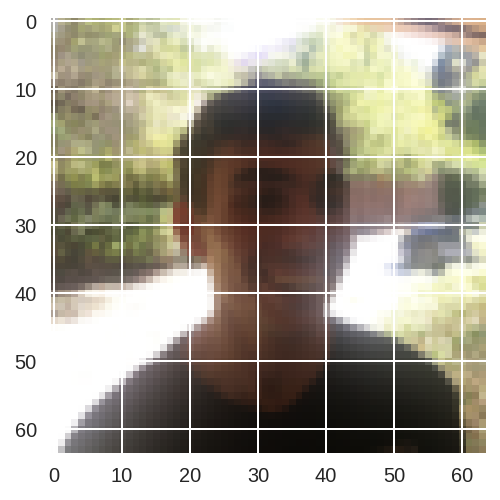

In [6]:
index=6
plt.imshow(X_train[index])
print ("y = " + str(np.squeeze(Y_train[index, :])))

In [0]:
def plot(history, accuracy, optimizer, lr=.01):
    plt.plot(history.history['acc'])
    plt.title('Optimizer: ' + str(optimizer) + ', Learning_rate: ' + str(lr) + ', Accuracy: ' + str(accuracy*100) + '%')
    plt.xlabel('epoch')
    plt.legend(loc='upper left')
    plt.show()

## Model

### Model Building

In [0]:
def HappyModel(input_shape):
    """
    Implementation of the HappyModel.
    
    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in Keras
    """
    
    model = Sequential()

    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same',input_shape = input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same',activation ='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same'))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    #Output Layer
    model.add(Dense(units = 1,kernel_initializer="uniform", activation = 'sigmoid'))

    return model

In [9]:
model = HappyModel(input_shape)
model.summary()
optimizer = RMSprop(lr=0.001, epsilon=1e-08, decay=0.0)
# Compiling Neural Network
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)  

In [0]:
BATCH_SIZE = 64
EPOCHS = 35

In [11]:
model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=35)

Instructions for updating:
Use tf.cast instead.
Epoch 1/35
480/480 [==============================] - 5s 11ms/step - loss: 0.4993 - acc: 0.7312
Epoch 2/35
480/480 [==============================] - 1s 1ms/step - loss: 0.3237 - acc: 0.8667
Epoch 3/35
480/480 [==============================] - 1s 1ms/step - loss: 0.2271 - acc: 0.9083
Epoch 4/35
480/480 [==============================] - 1s 1ms/step - loss: 0.1735 - acc: 0.9417
Epoch 5/35
480/480 [==============================] - 1s 1ms/step - loss: 0.1827 - acc: 0.9354
Epoch 6/35
480/480 [==============================] - 1s 1ms/step - loss: 0.1293 - acc: 0.9396
Epoch 7/35
480/480 [==============================] - 1s 1ms/step - loss: 0.1359 - acc: 0.9500
Epoch 8/35
480/480 [==============================] - 1s 1ms/step - loss: 0.0992 - acc: 0.9625
Epoch 9/35
480/480 [==============================] - 1s 1ms/step - loss: 0.0976 - acc: 0.9688
Epoch 10/35
480/480 [==============================] - 1s 1ms/step - loss: 0.1022 - acc: 0.9667


## Hyperparameter Tuning

In [0]:
model = HappyModel(input_shape)
best_lr=.01

In [0]:
optimizers = [tf.train.AdagradOptimizer, tf.train.AdadeltaOptimizer, tf.train.AdamOptimizer,
              tf.train.GradientDescentOptimizer, tf.train.RMSPropOptimizer]
lrs = [.01, .1, 1, 10, 100]

In [0]:
max_acc = -1
best_opt = tf.train.AdagradOptimizer(best_lr)

120/120 [==============================] - 0s 3ms/step


No handles with labels found to put in legend.


[0.12322610318660736, 0.9583333452542623]


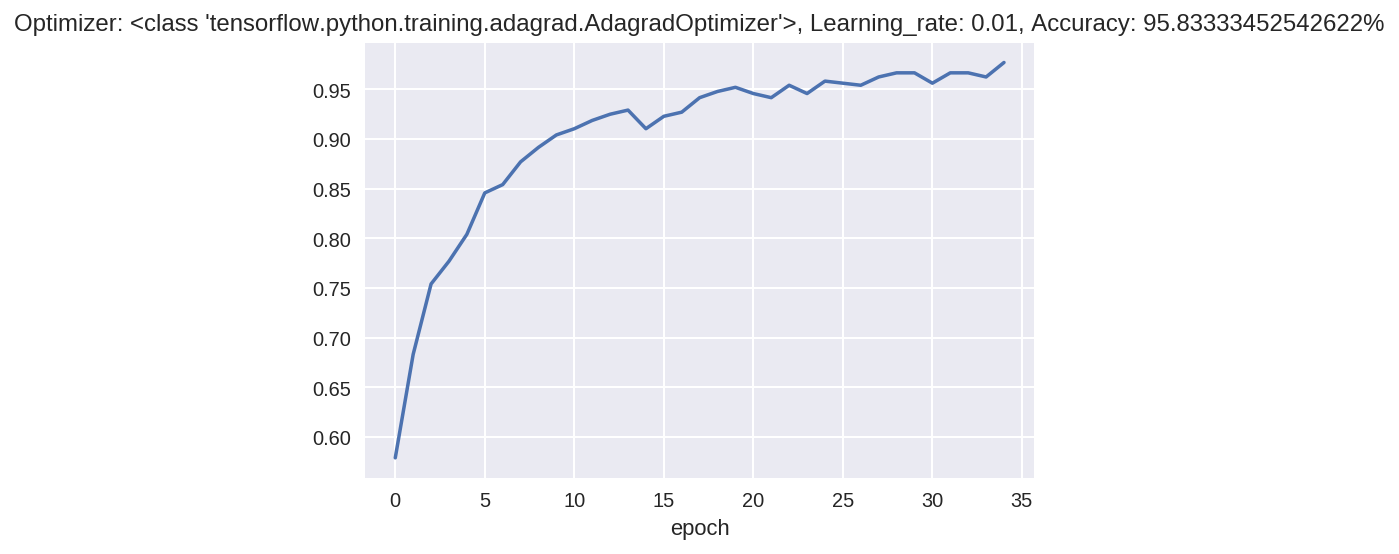

120/120 [==============================] - 0s 3ms/step


No handles with labels found to put in legend.


[0.5850080092748006, 0.7416666746139526]


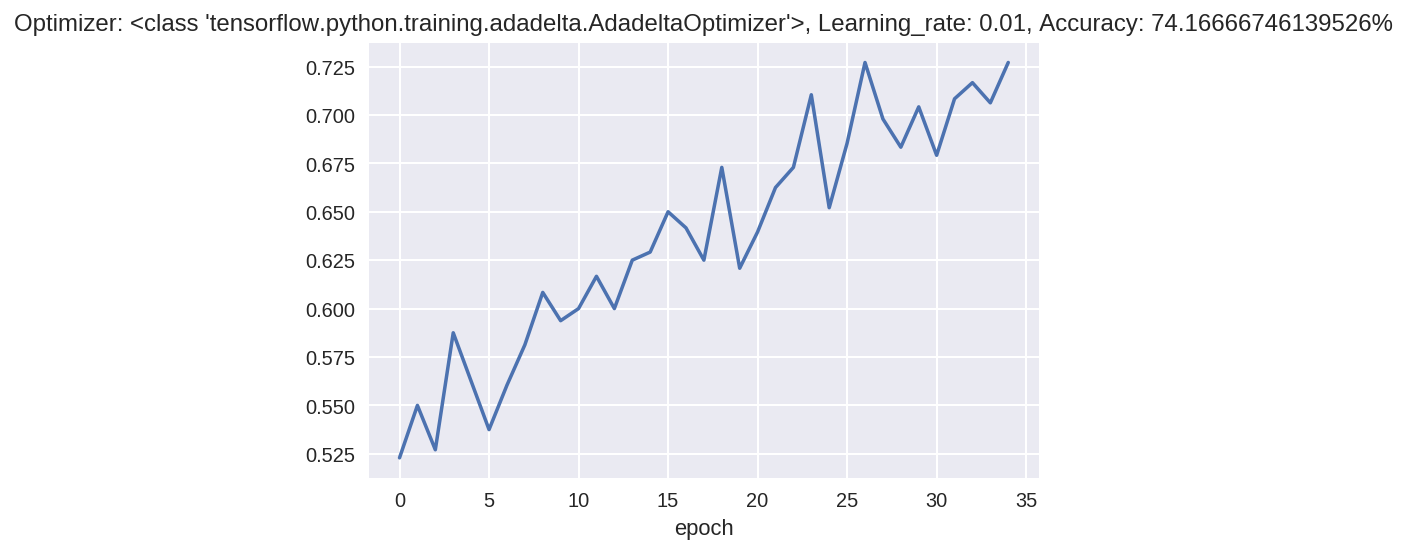

120/120 [==============================] - 1s 4ms/step


No handles with labels found to put in legend.


[0.7265984455744425, 0.8333333373069763]


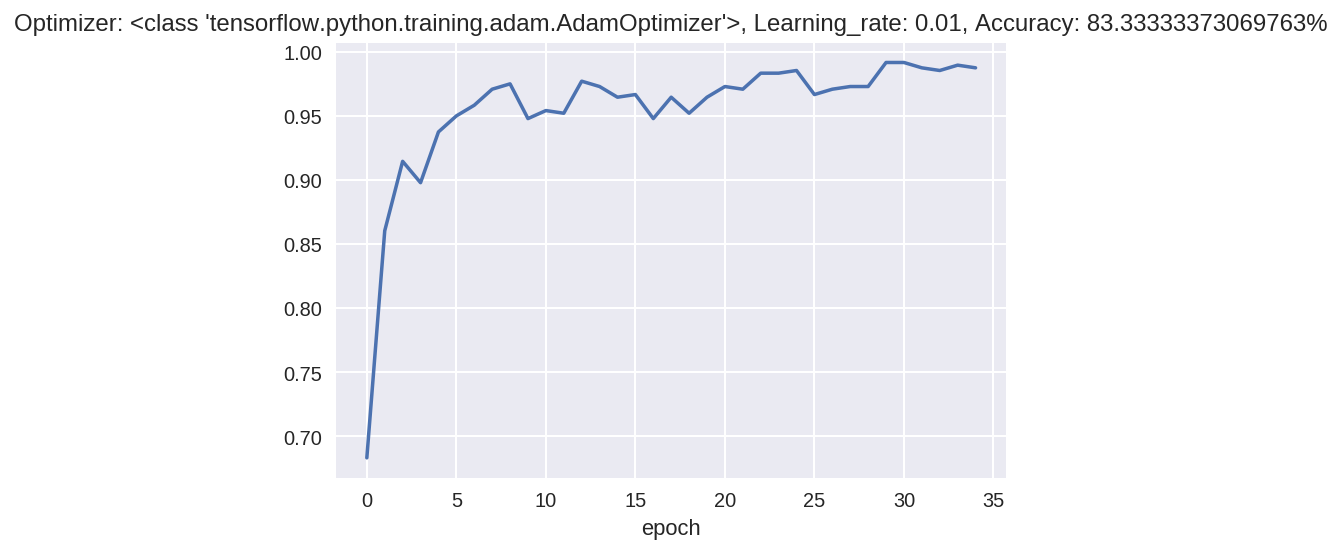

120/120 [==============================] - 1s 5ms/step


No handles with labels found to put in legend.


[0.37197865049044293, 0.7916666626930237]


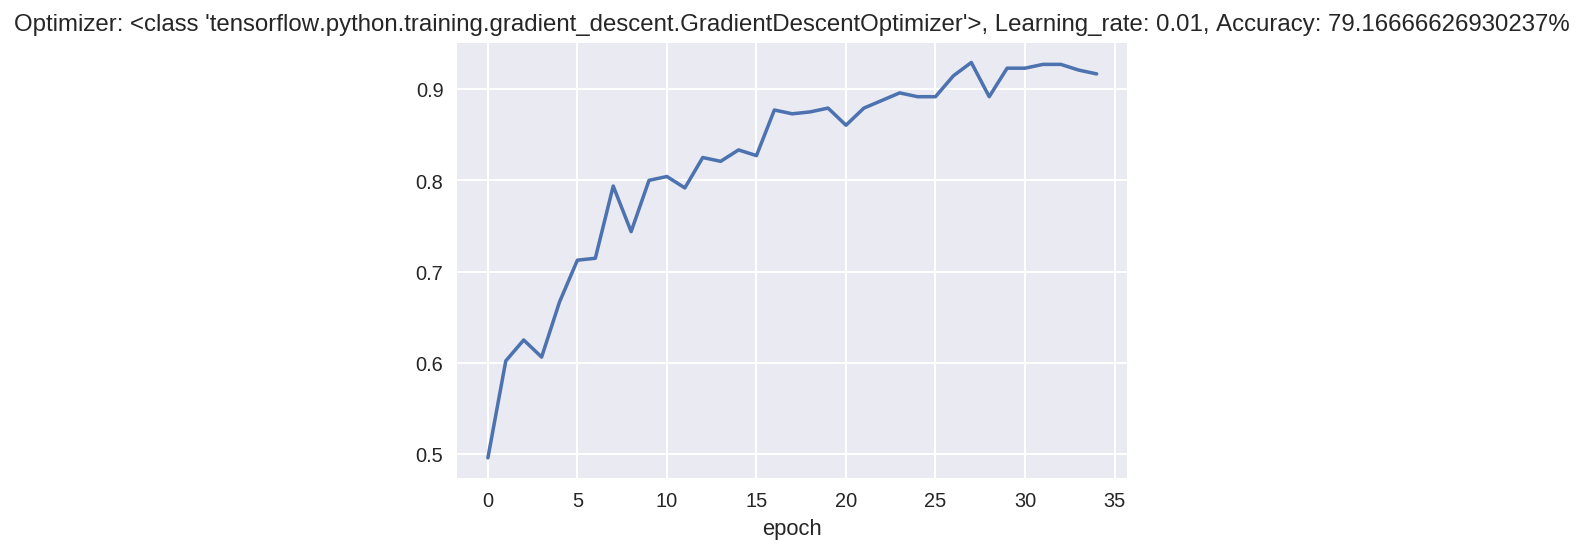

120/120 [==============================] - 1s 6ms/step


No handles with labels found to put in legend.


[1.0458553910255433, 0.8916666587193807]


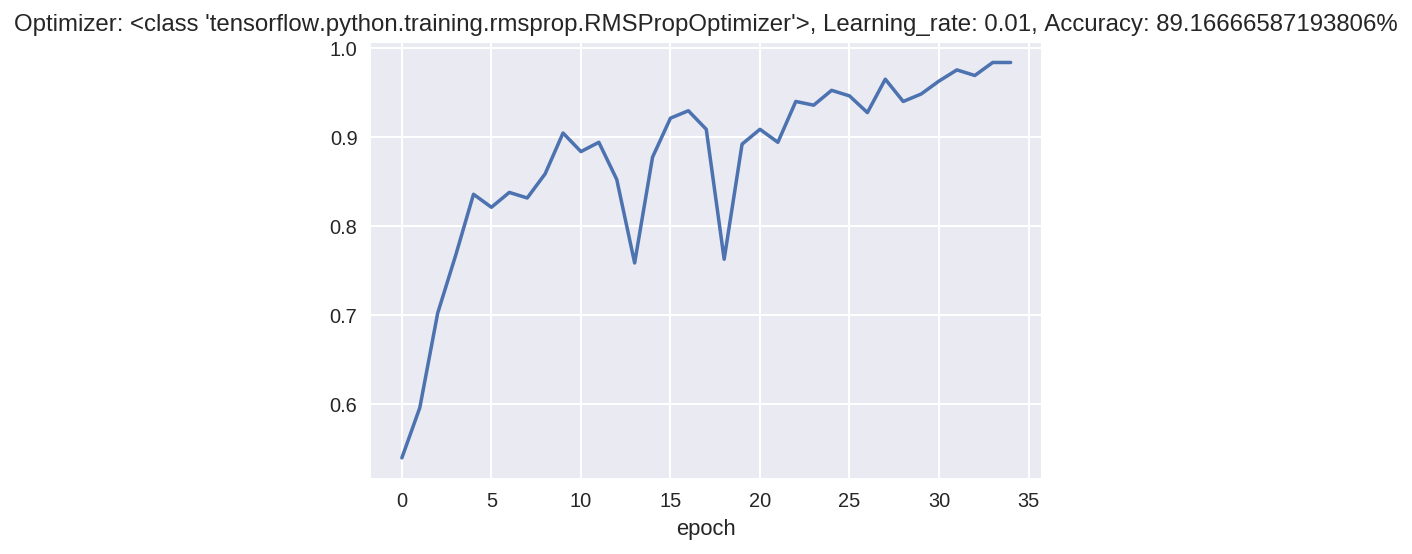

In [15]:
for optimizer in optimizers:
    model = HappyModel(input_shape)
    model.compile(optimizer=optimizer(best_lr), loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, Y_train, verbose = 0, epochs=EPOCHS, batch_size=BATCH_SIZE)
    score = model.evaluate(X_val, Y_val, batch_size=BATCH_SIZE)
    print(score)
    plot(history, score[1], optimizer, best_lr)
    if score[1] > max_acc:
        max_acc = score[1]
        best_opt = optimizer

In [0]:
max_acc=-1
best_lr=1

120/120 [==============================] - 1s 7ms/step


No handles with labels found to put in legend.


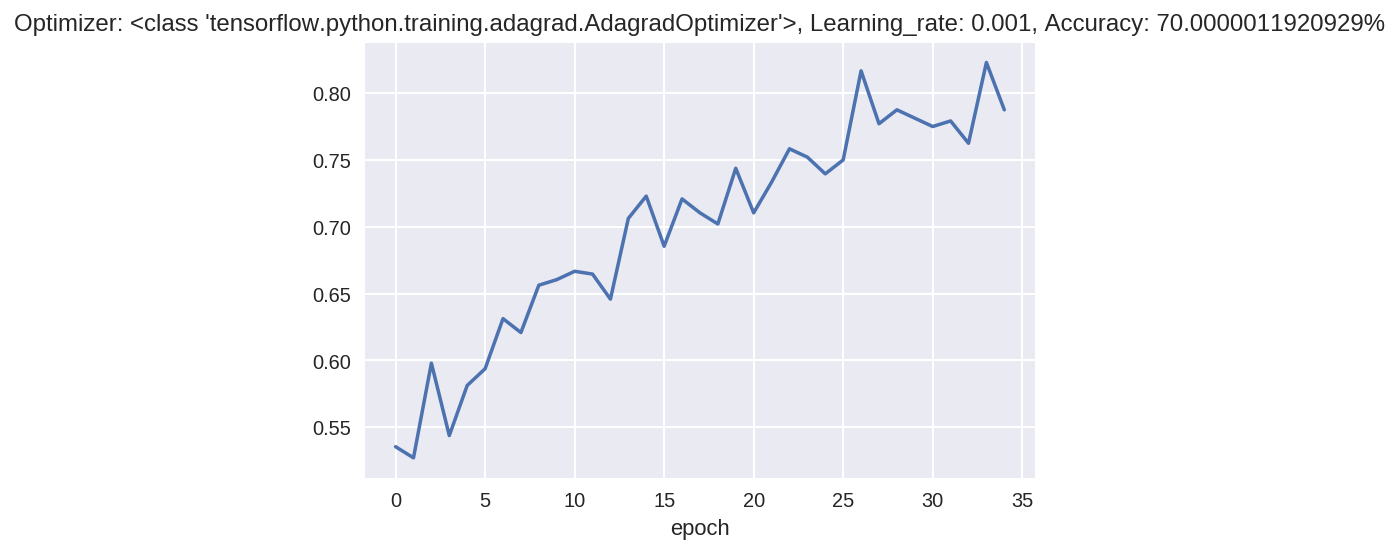

120/120 [==============================] - 1s 8ms/step


No handles with labels found to put in legend.


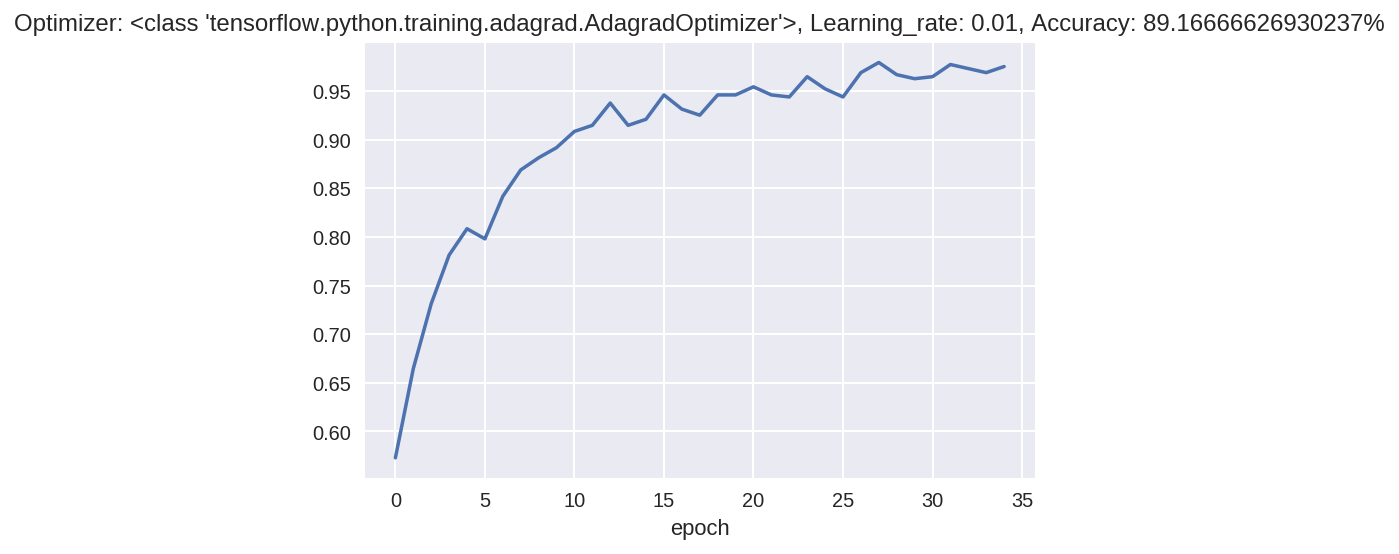

120/120 [==============================] - 1s 9ms/step


No handles with labels found to put in legend.


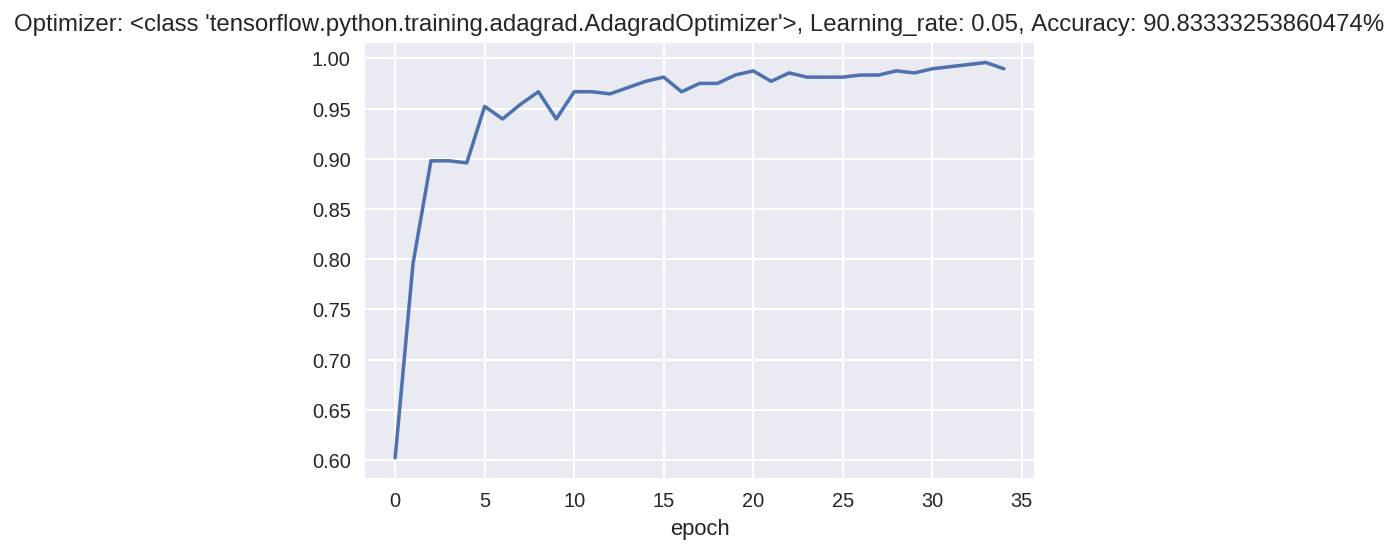

120/120 [==============================] - 1s 10ms/step


No handles with labels found to put in legend.


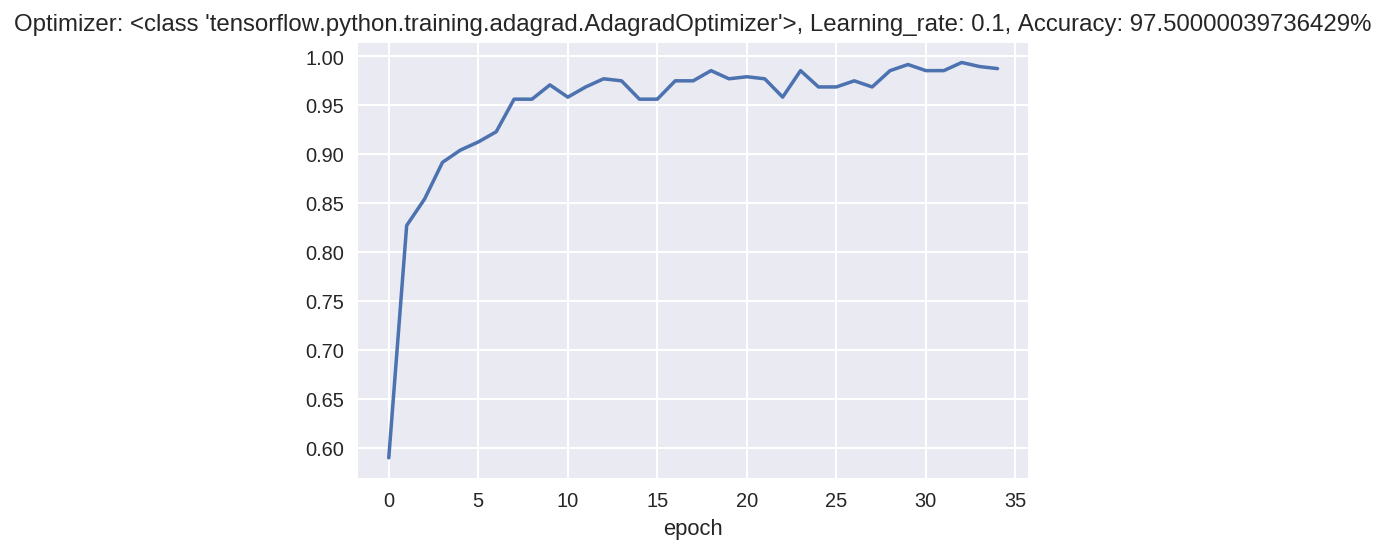

120/120 [==============================] - 1s 12ms/step


No handles with labels found to put in legend.


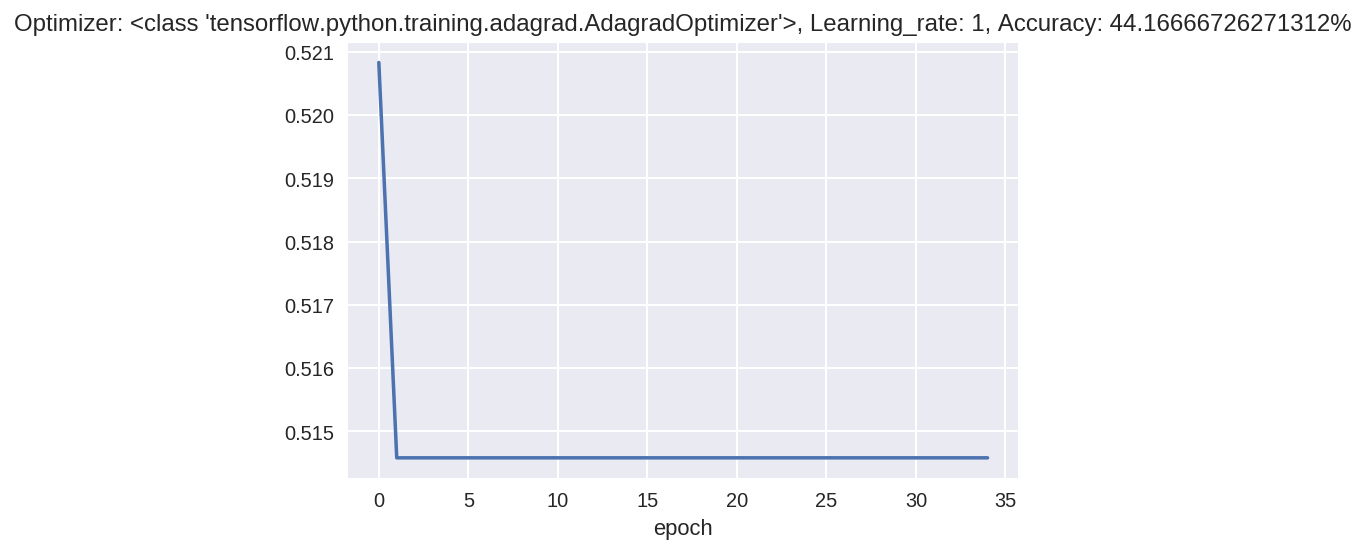

120/120 [==============================] - 2s 13ms/step


No handles with labels found to put in legend.


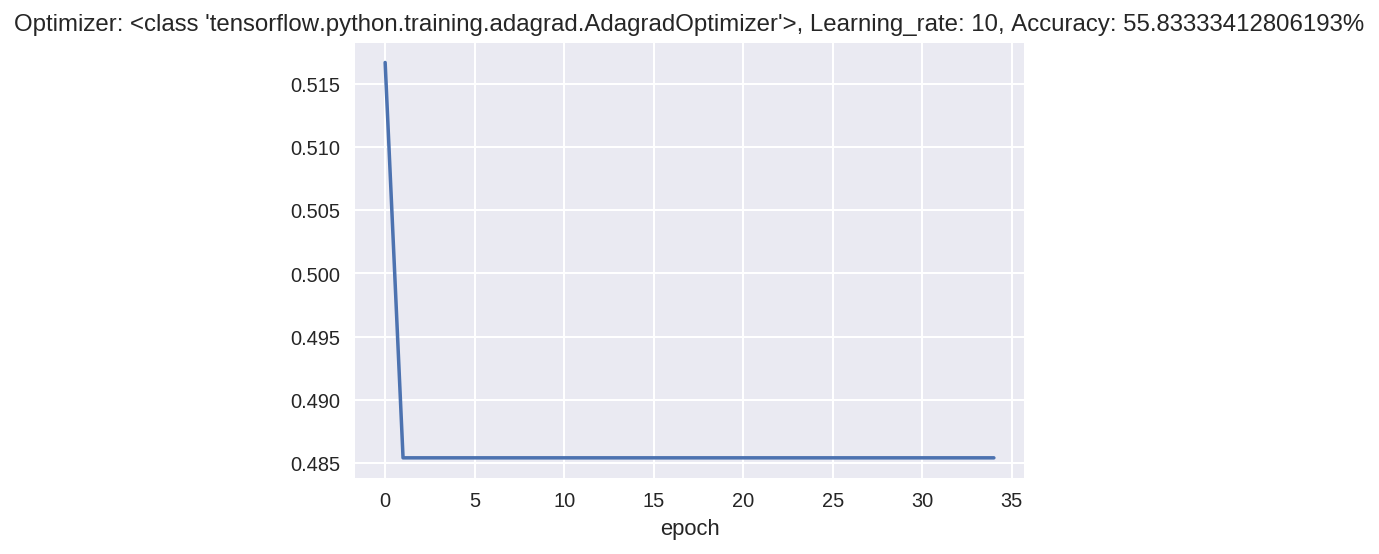

120/120 [==============================] - 2s 14ms/step


No handles with labels found to put in legend.


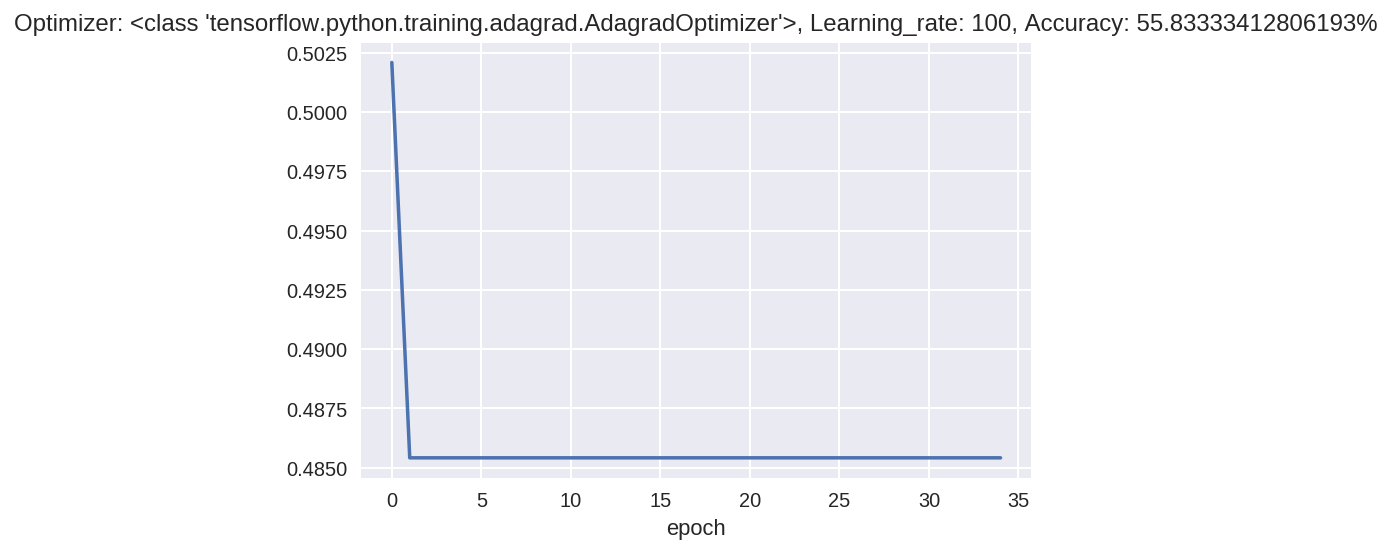

In [17]:
for lr in lrs:
    model = HappyModel(input_shape)
    model.compile(optimizer=best_opt(lr), loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, Y_train, verbose = 0, epochs=EPOCHS, batch_size=BATCH_SIZE)
    score = model.evaluate(X_val, Y_val, batch_size=BATCH_SIZE)
    plot(history, score[1], best_opt, lr)
    if score[1] >= max_acc:
        max_acc = score[1]
        best_lr = lr

In [18]:
print(best_lr)

0.1


## Evaluation

150/150 [==============================] - 2s 13ms/step


No handles with labels found to put in legend.


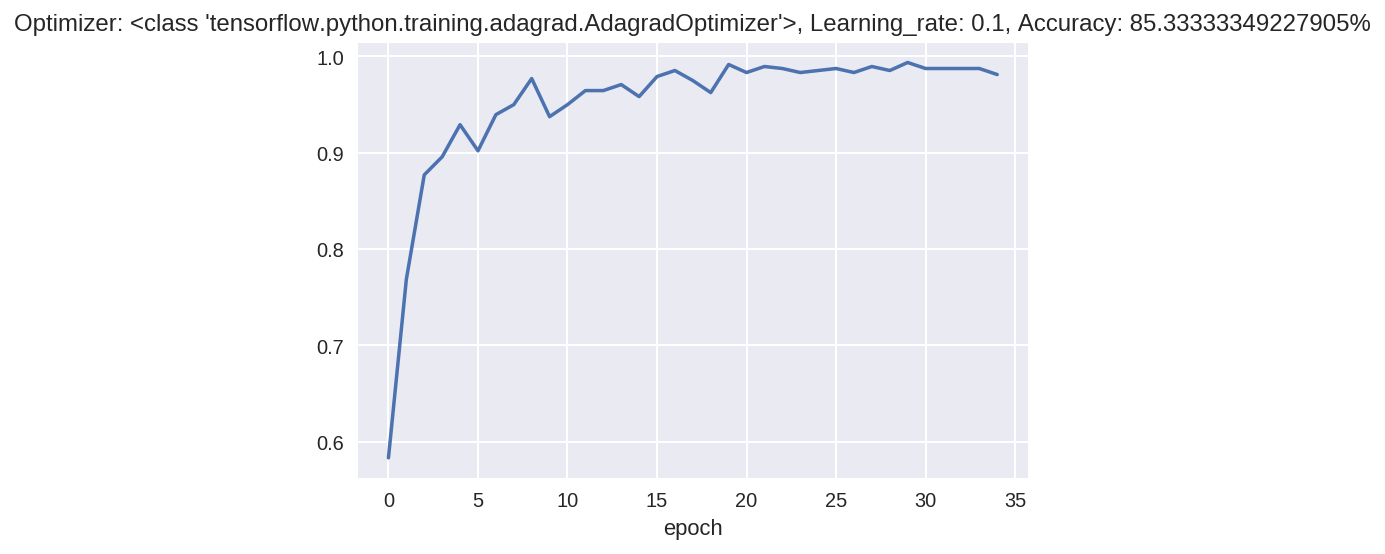

Time: 21.525622129440308


In [23]:
model = HappyModel(input_shape)
start = time()
model.compile(optimizer=best_opt(best_lr), loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, Y_train, verbose = 0, epochs=EPOCHS, batch_size=BATCH_SIZE)
end = time()
score = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)
plot(history, score[1], best_opt, best_lr)
print("Time: " + str(end - start))

[0]
[0.00027937]


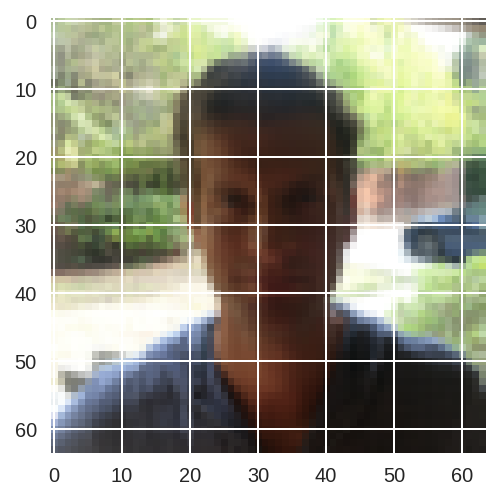

In [25]:
index = 13
print(Y_test[index])

plt.imshow(np.squeeze(X_test[index]), cmap=plt.cm.binary)

predictions = model.predict(X_test)
print(predictions[index])

In [0]:
def build_vgg():
  model = Sequential()
  model.add(VGG19(weights= None, include_top=False, input_shape=input_shape))
  model.add(Flatten())
  model.add(Dense(units=1, activation= 'sigmoid'))
  return model

120/120 [==============================] - 4s 34ms/step


No handles with labels found to put in legend.


[0.6952186544736226, 0.44166667262713116]


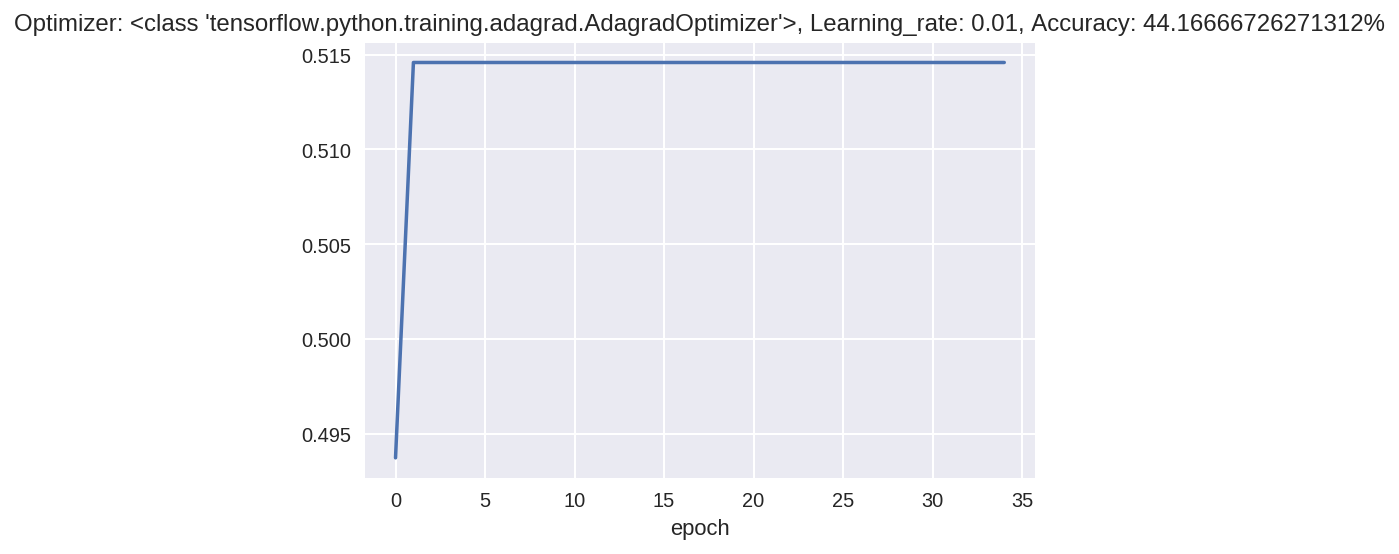

120/120 [==============================] - 4s 35ms/step


No handles with labels found to put in legend.


[0.6935760815938313, 0.44166667262713116]


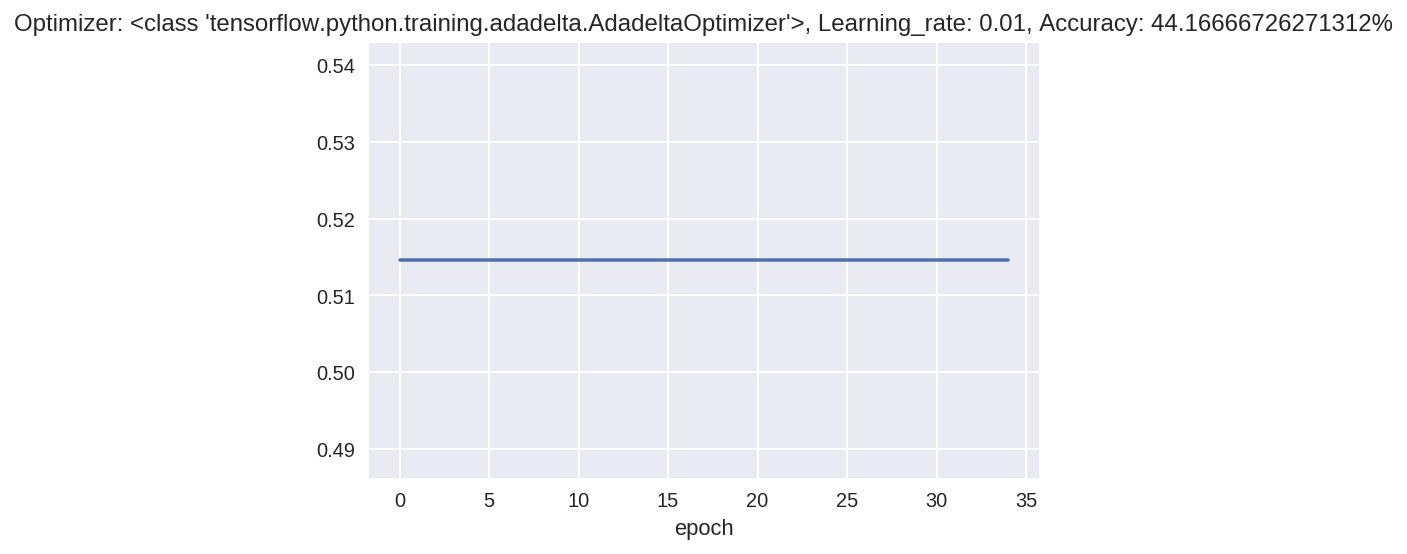

120/120 [==============================] - 4s 36ms/step


No handles with labels found to put in legend.


[7.041219997406006, 0.5583333412806193]


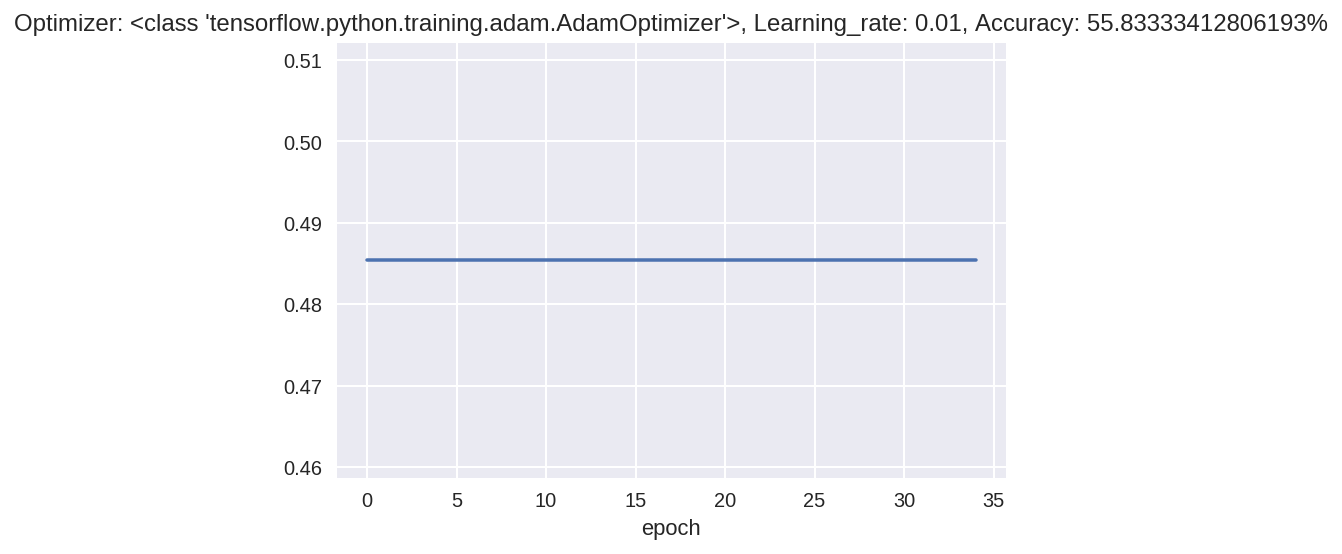

120/120 [==============================] - 4s 37ms/step


No handles with labels found to put in legend.


[0.6964464505513509, 0.44166667262713116]


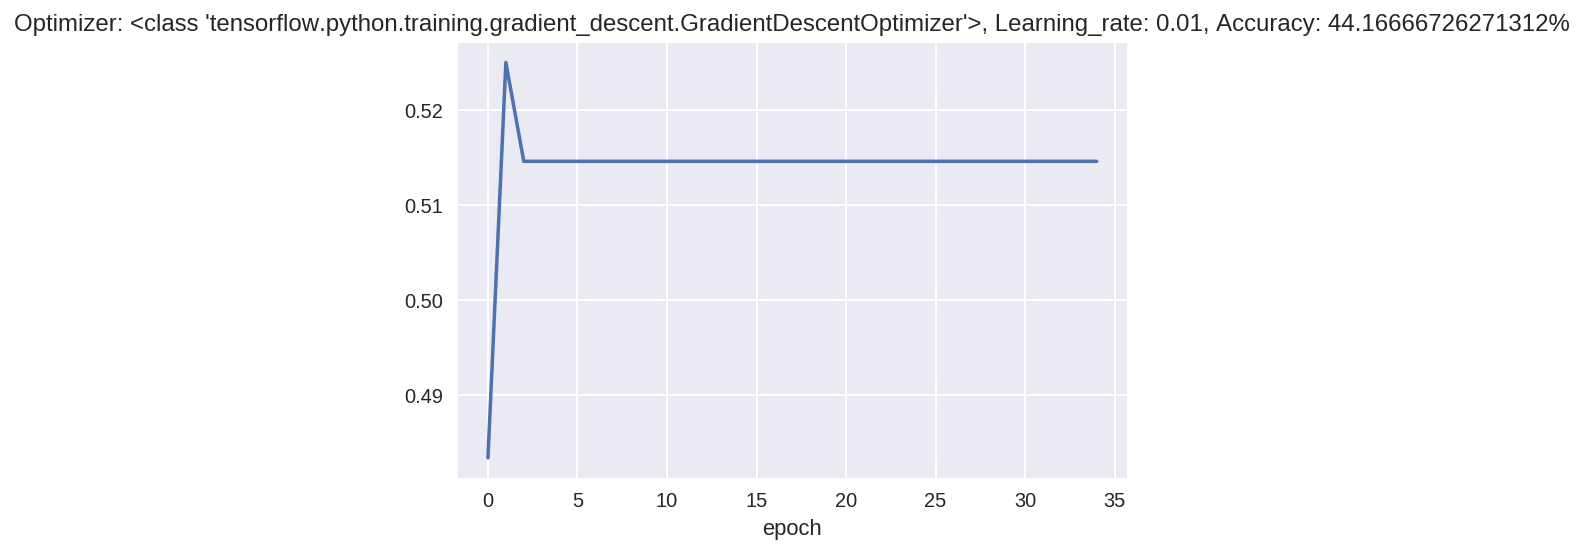

120/120 [==============================] - 5s 38ms/step


No handles with labels found to put in legend.


[8.999269994099935, 0.44166667262713116]


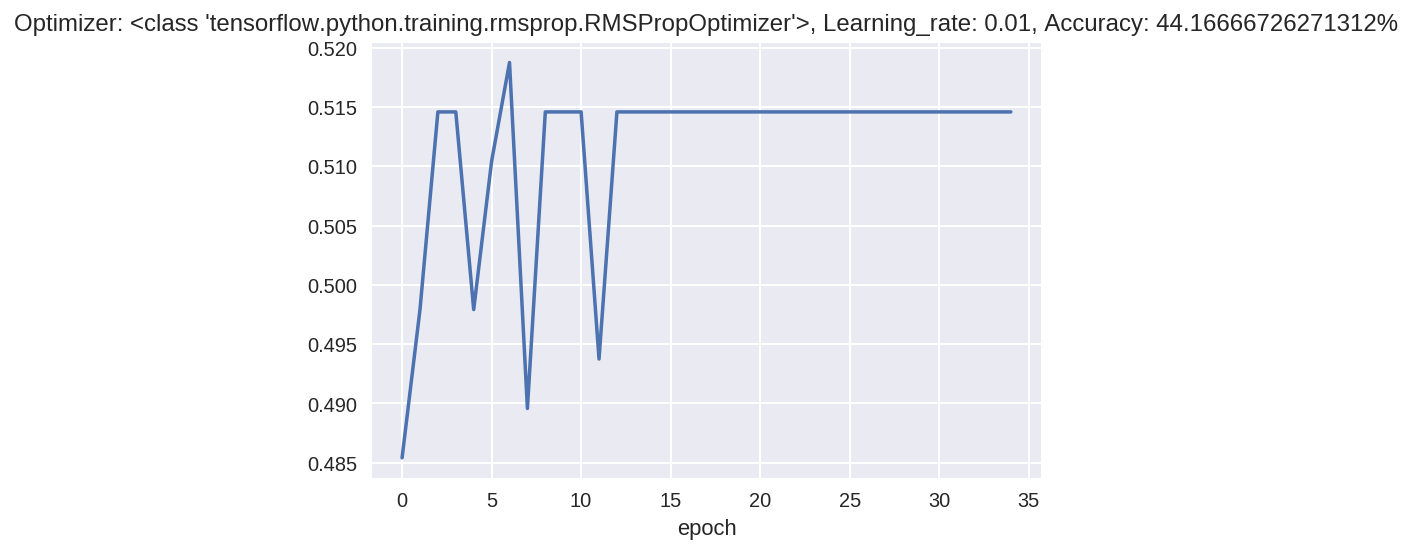

In [36]:
max_acc=-1
best_lr=.01
for optimizer in optimizers:
    model = build_vgg()
    model.compile(optimizer=optimizer(best_lr), loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, Y_train, verbose = 0, epochs=EPOCHS)
    score = model.evaluate(X_val, Y_val, batch_size=BATCH_SIZE)
    print(score)
    plot(history, score[1], optimizer, best_lr)
    if score[1] > max_acc:
        max_acc = score[1]
        best_opt = optimizer

120/120 [==============================] - 5s 44ms/step


No handles with labels found to put in legend.


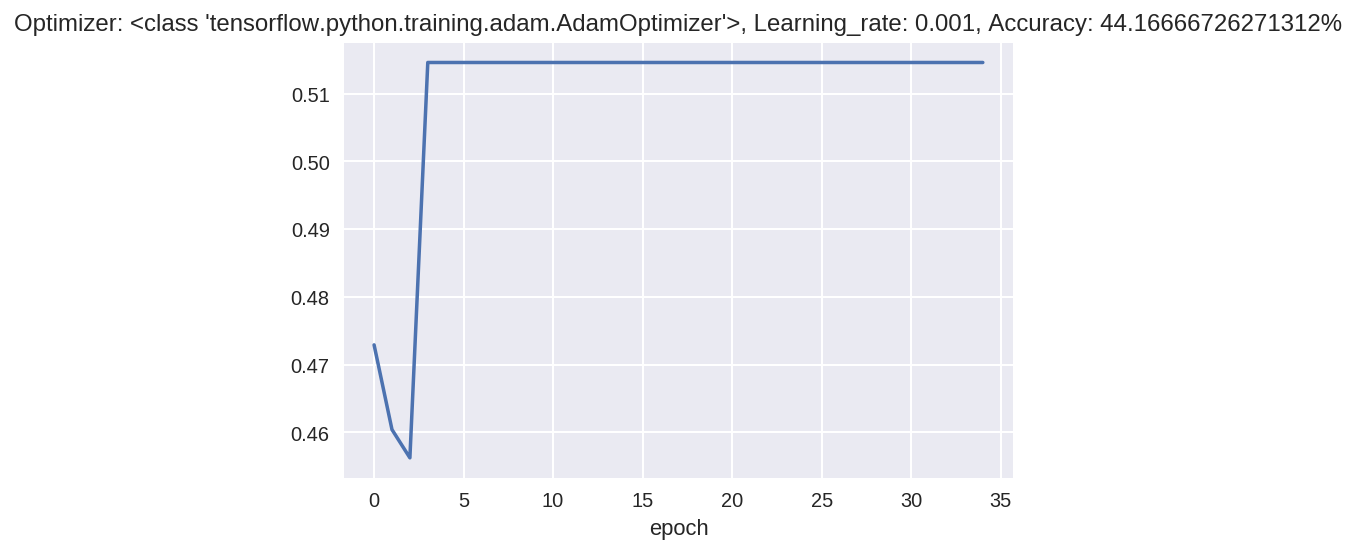

120/120 [==============================] - 5s 45ms/step


No handles with labels found to put in legend.


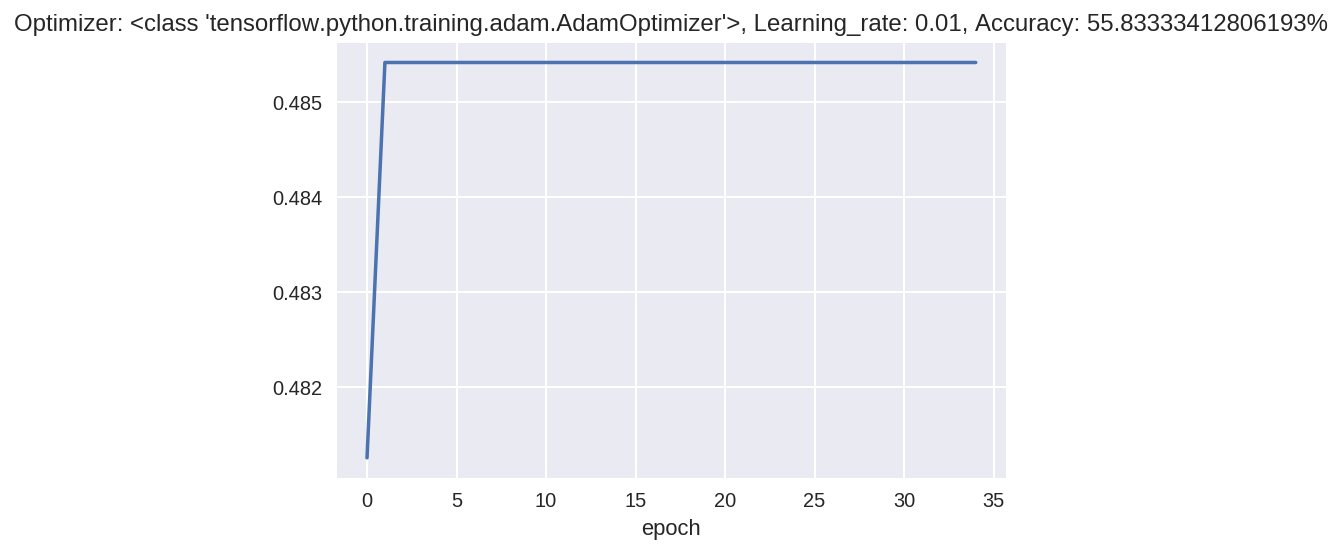

120/120 [==============================] - 6s 47ms/step


No handles with labels found to put in legend.


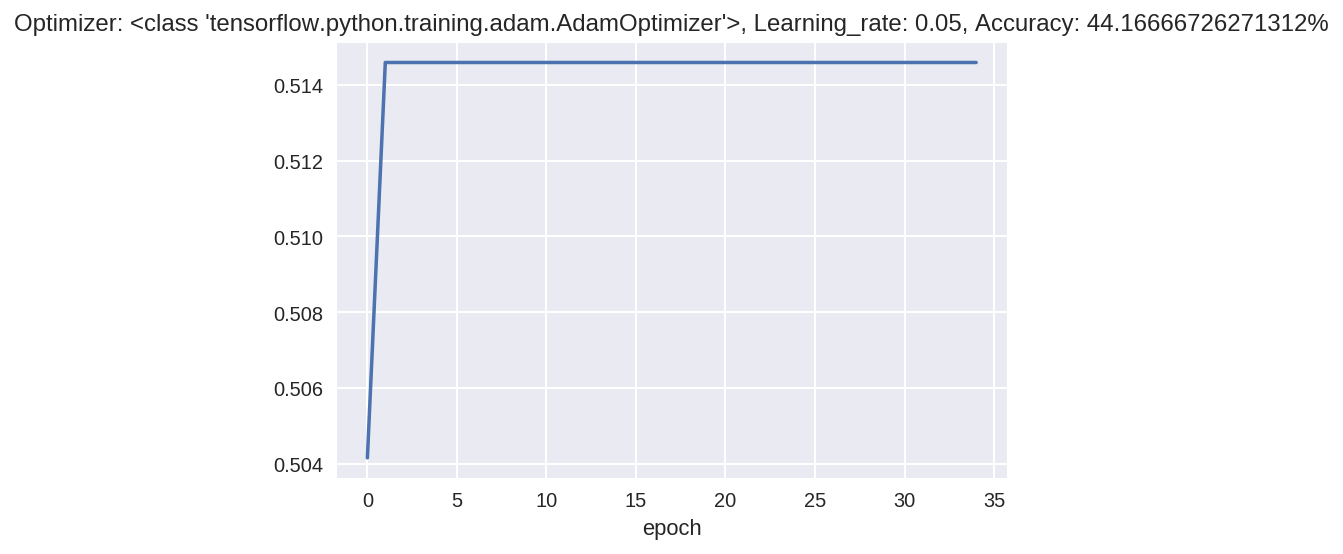

120/120 [==============================] - 6s 48ms/step


No handles with labels found to put in legend.


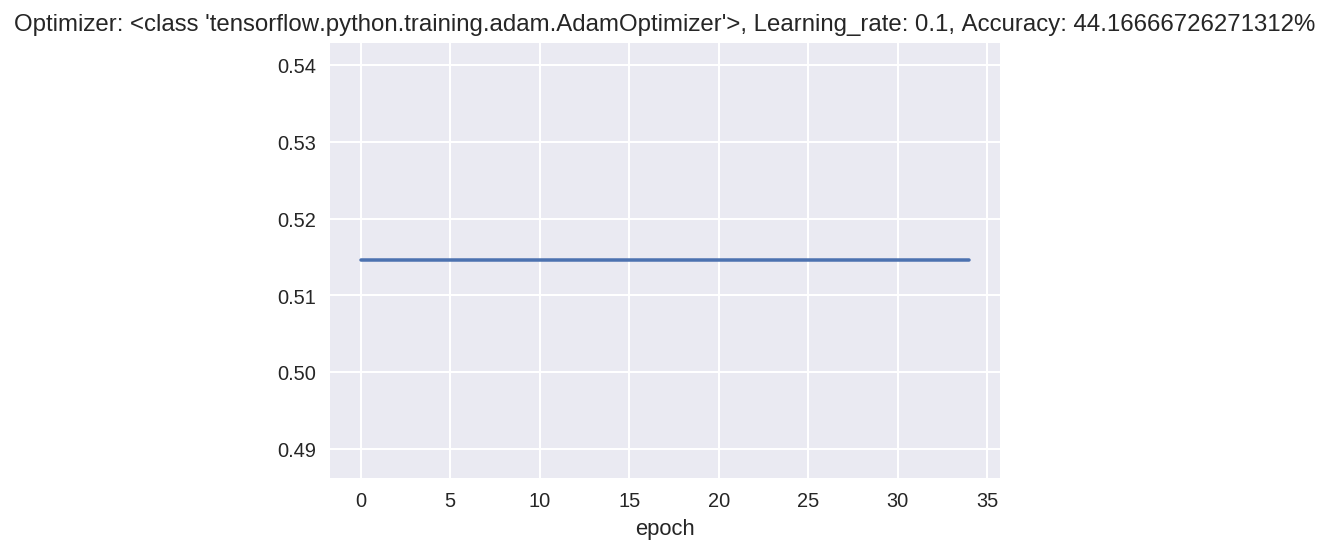

120/120 [==============================] - 6s 49ms/step


No handles with labels found to put in legend.


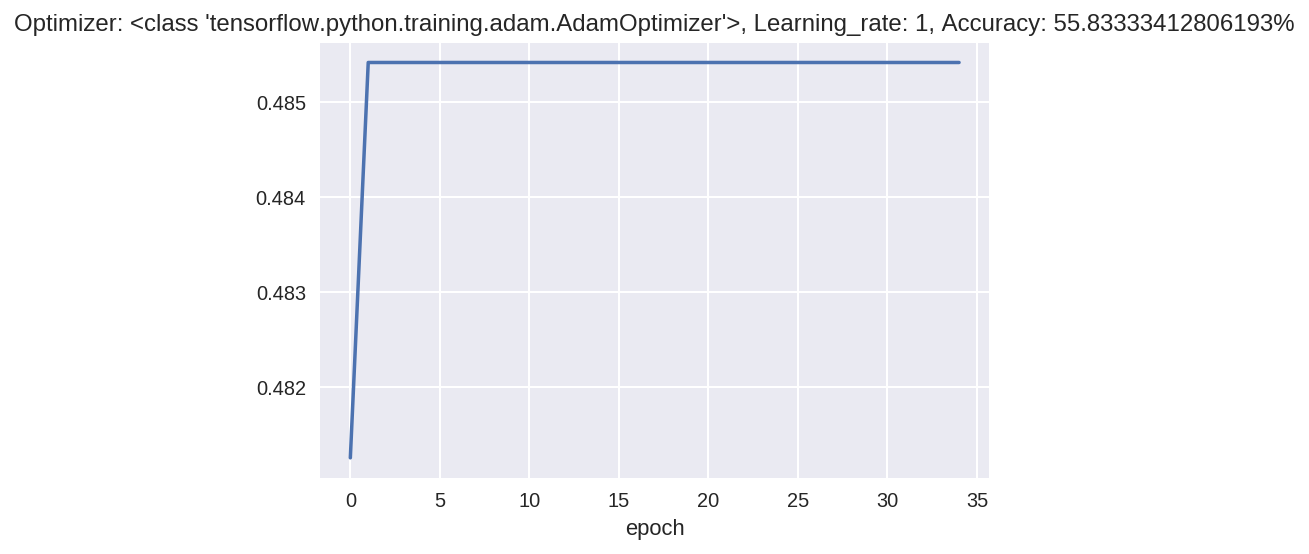

120/120 [==============================] - 6s 50ms/step


No handles with labels found to put in legend.


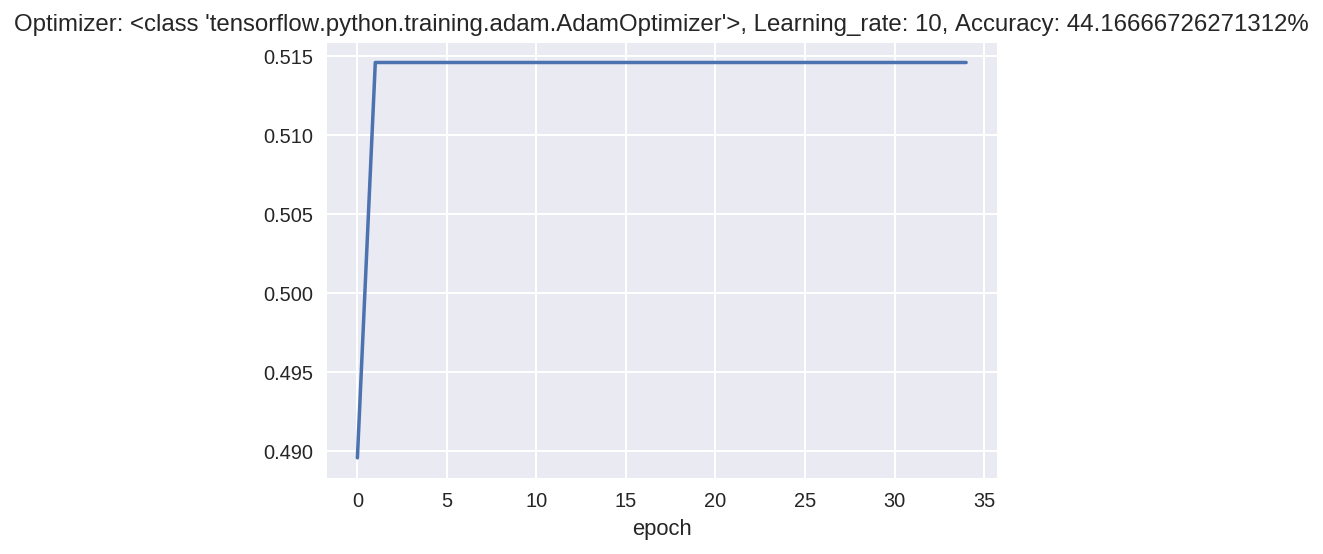

120/120 [==============================] - 6s 52ms/step


No handles with labels found to put in legend.


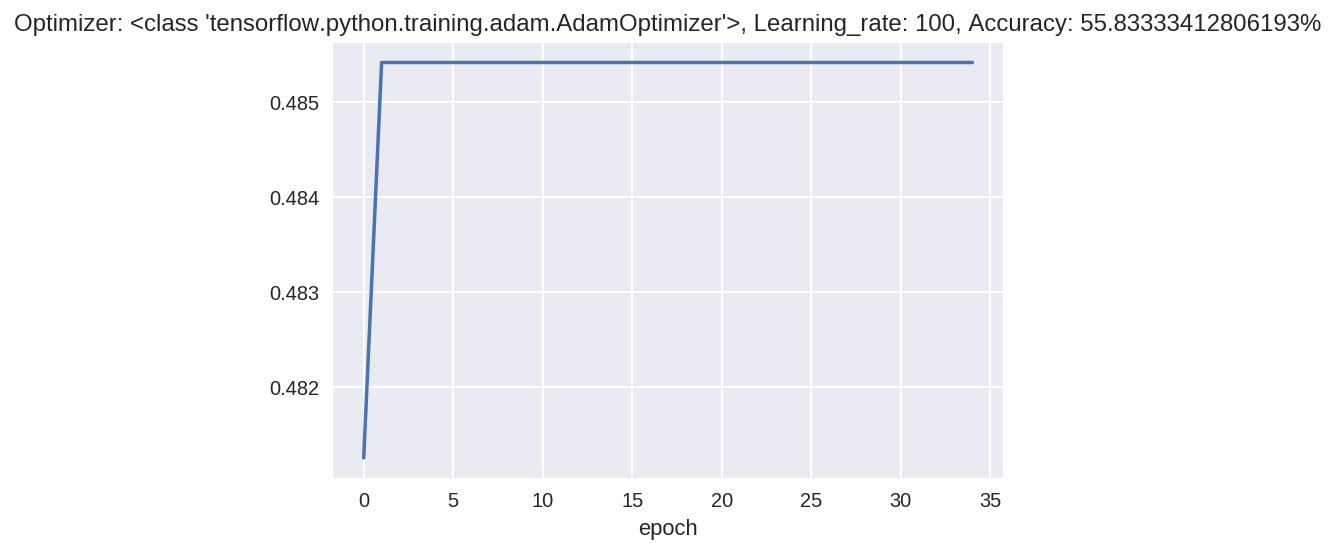

In [38]:
max_acc=-1
for lr in lrs:
    model = build_vgg()
    model.compile(optimizer=best_opt(lr), loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, Y_train, verbose = 0, epochs=EPOCHS, batch_size=BATCH_SIZE)
    score = model.evaluate(X_val, Y_val, batch_size=BATCH_SIZE)
    plot(history, score[1], best_opt, lr)
    if score[1] >= max_acc:
        max_acc = score[1]
        best_lr = lr

In [0]:
def build_resnet():
  model = Sequential()
  model.add(ResNet50(weights= None, include_top=False, input_shape=input_shape))
  model.add(Flatten())
  model.add(Dense(units=1, activation= 'sigmoid'))
  return model

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


120/120 [==============================] - 2s 19ms/step


No handles with labels found to put in legend.


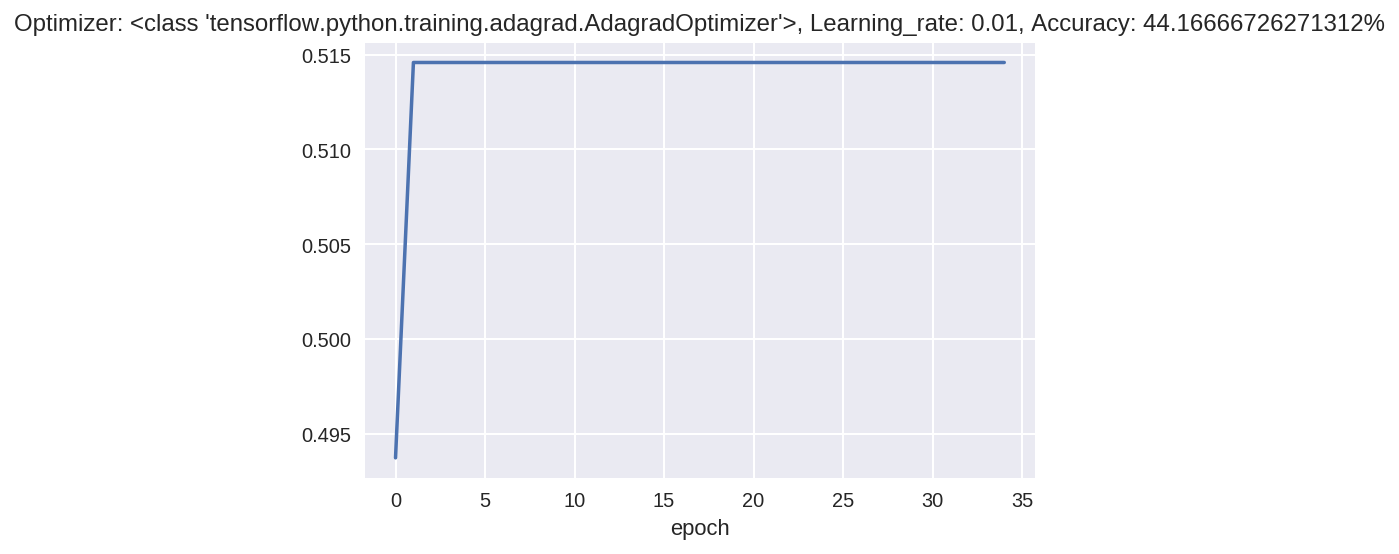

120/120 [==============================] - 4s 32ms/step


No handles with labels found to put in legend.


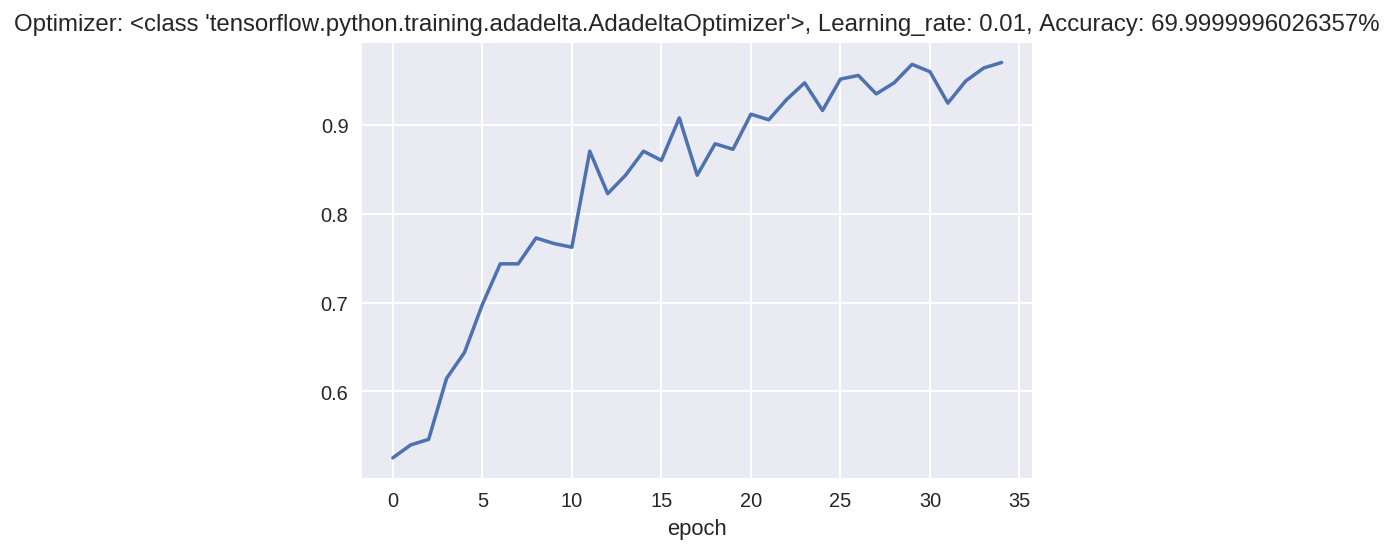

120/120 [==============================] - 6s 46ms/step


No handles with labels found to put in legend.


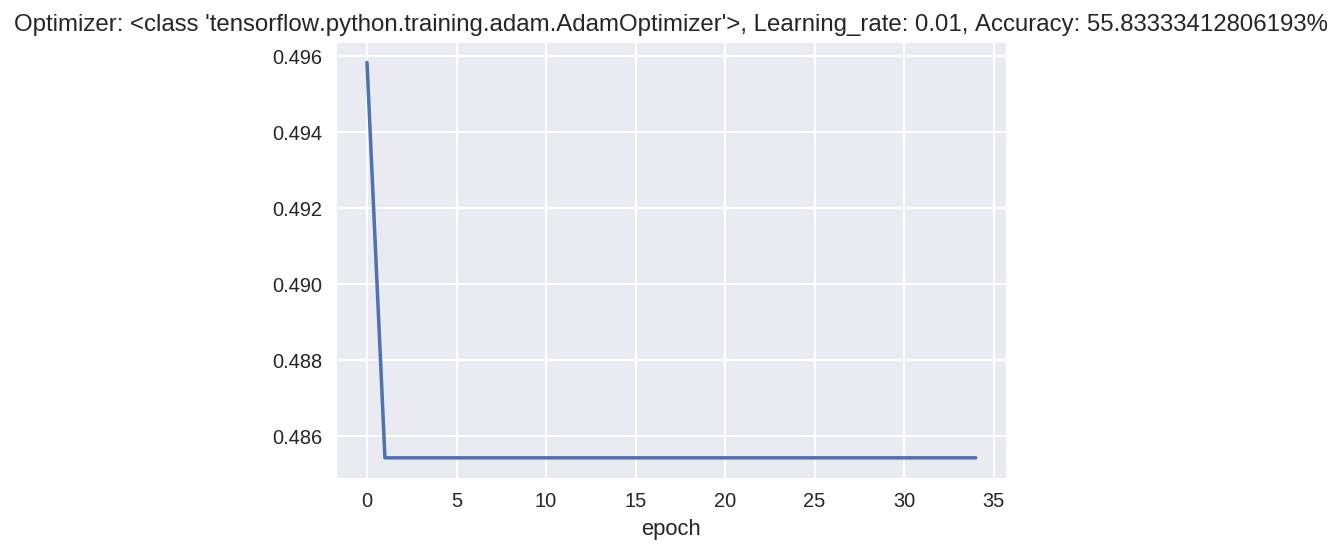

120/120 [==============================] - 7s 61ms/step


No handles with labels found to put in legend.


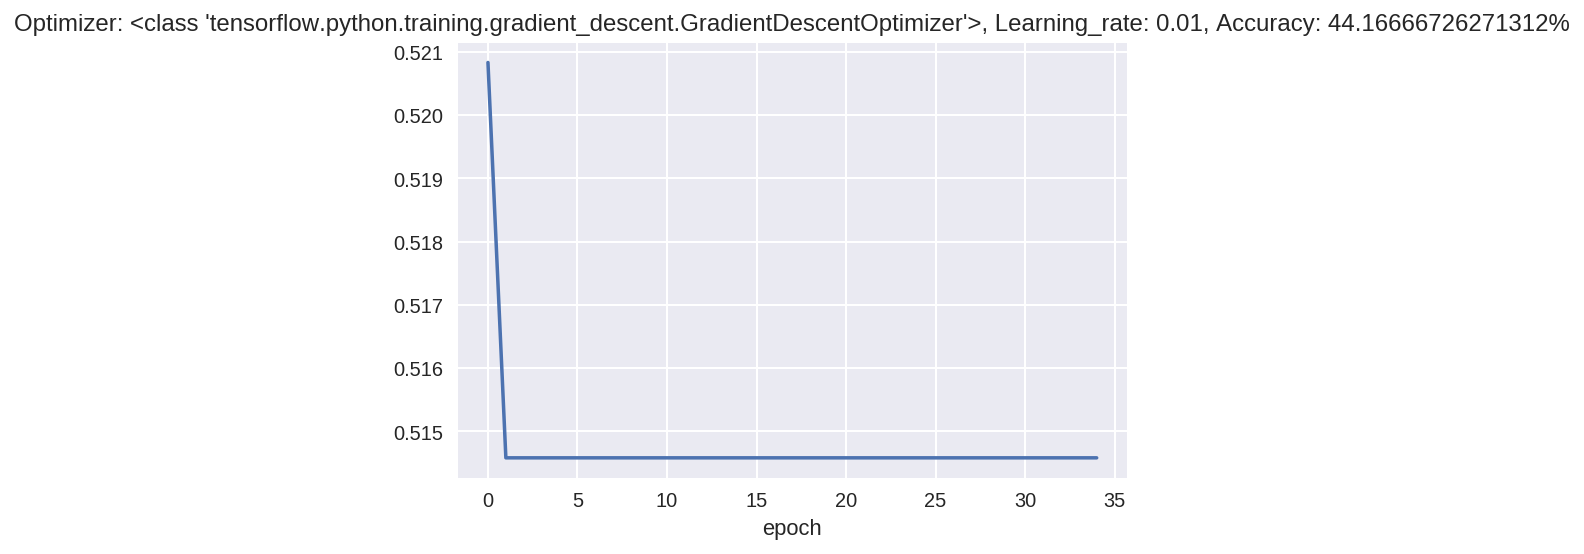

120/120 [==============================] - 10s 80ms/step


No handles with labels found to put in legend.


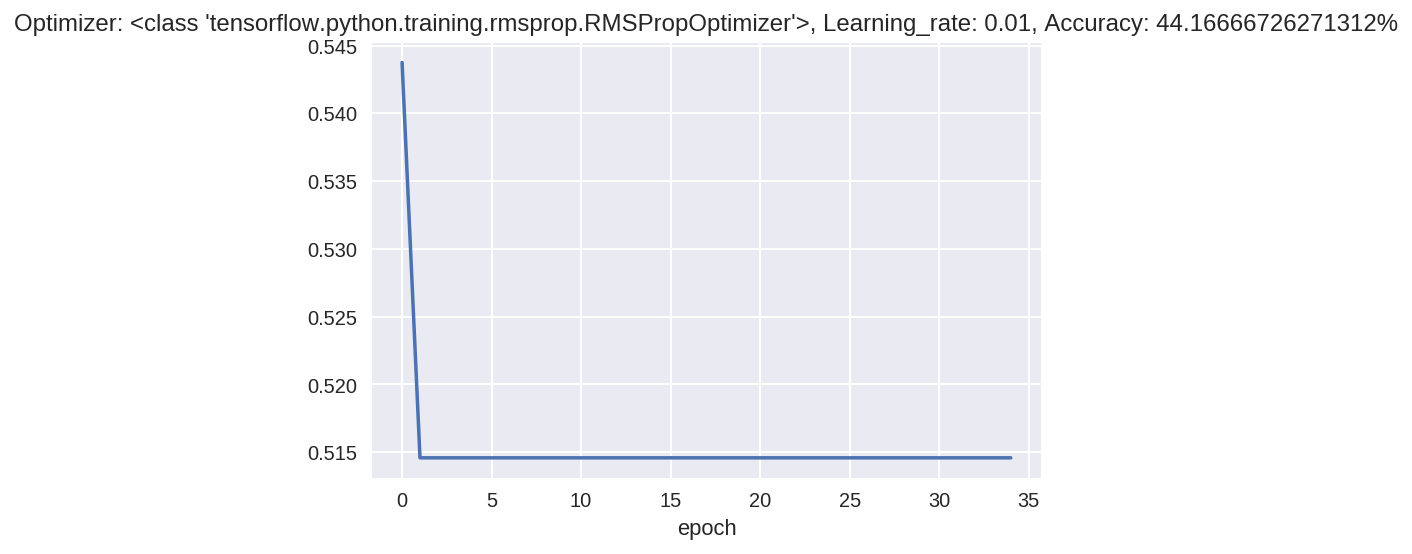

In [14]:
max_acc=-1
best_lr=.01
for optimizer in optimizers:
    model = build_resnet()
    model.compile(optimizer=optimizer(best_lr), loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, Y_train, verbose = 0, epochs=EPOCHS, batch_size=BATCH_SIZE)
    score = model.evaluate(X_val, Y_val, batch_size=BATCH_SIZE)
    plot(history, score[1], optimizer, best_lr)
    if score[1] > max_acc:
        max_acc = score[1]
        best_opt = optimizer

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


120/120 [==============================] - 13s 108ms/step


No handles with labels found to put in legend.


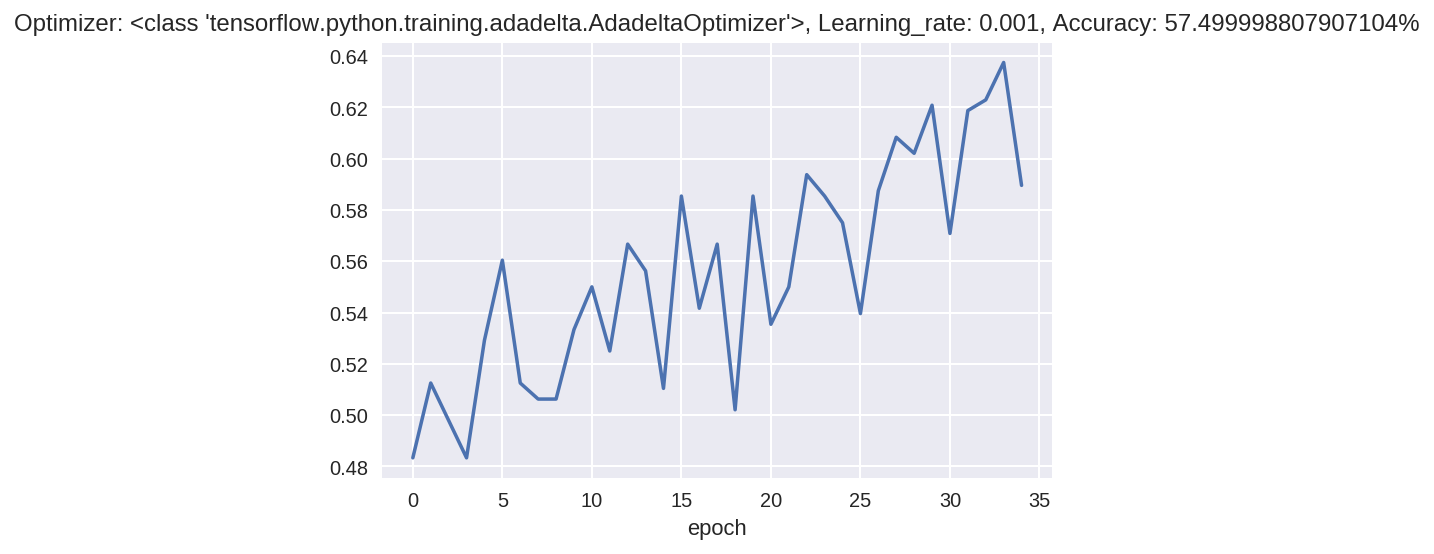

120/120 [==============================] - 16s 130ms/step


No handles with labels found to put in legend.


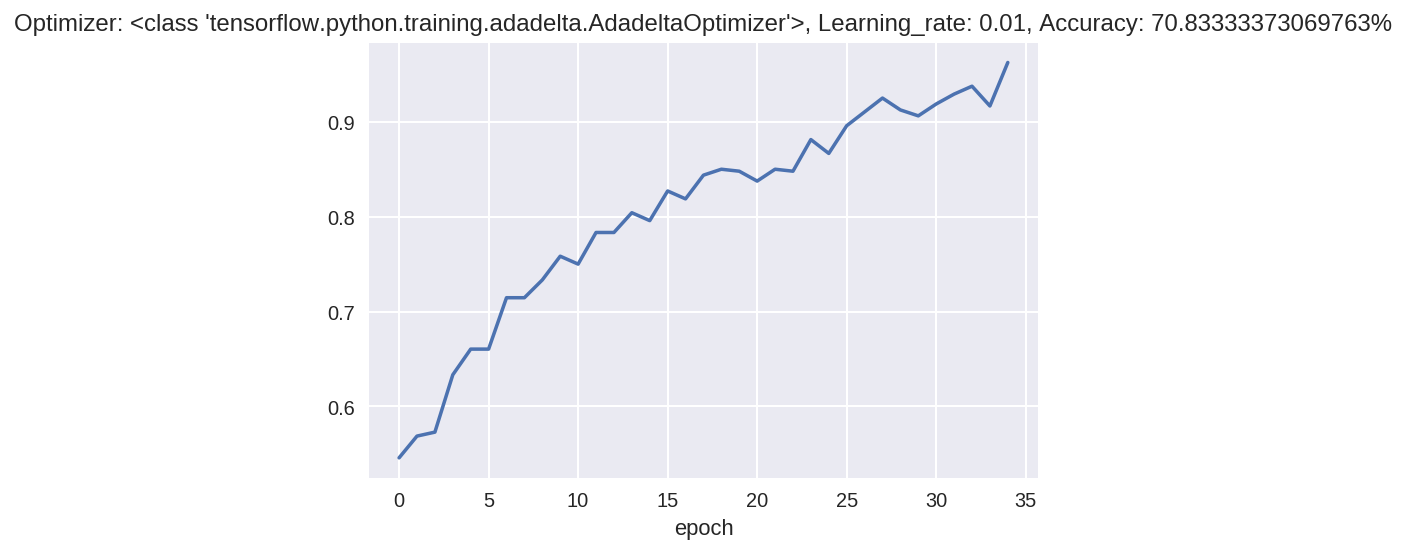

120/120 [==============================] - 19s 161ms/step


No handles with labels found to put in legend.


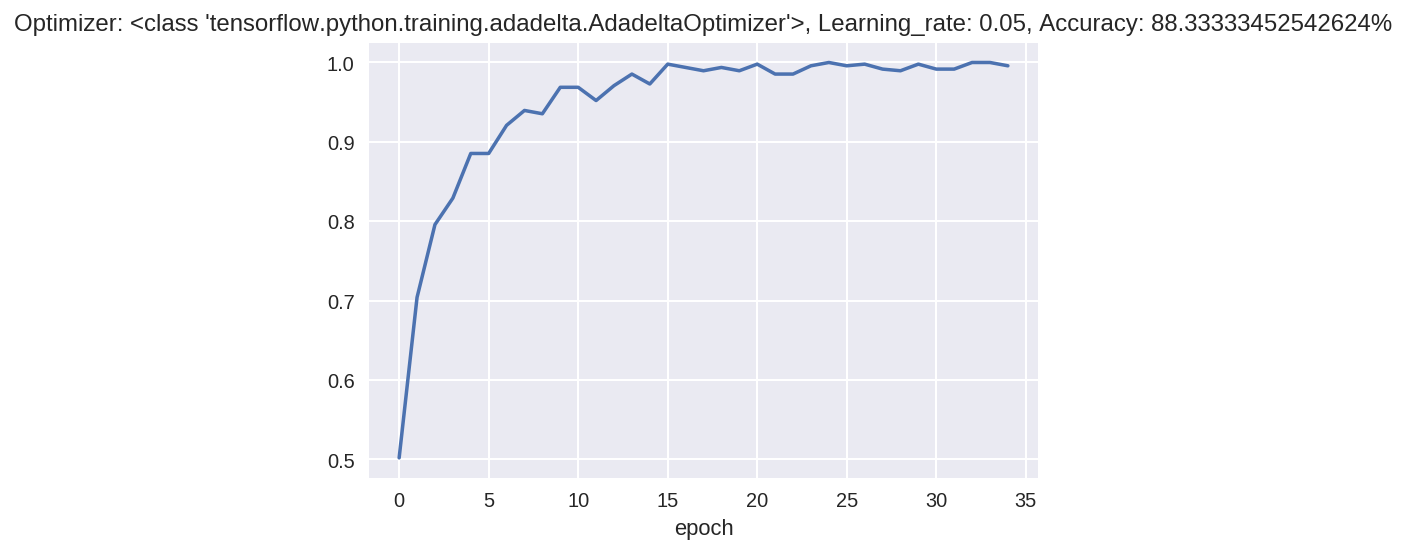

120/120 [==============================] - 23s 194ms/step


No handles with labels found to put in legend.


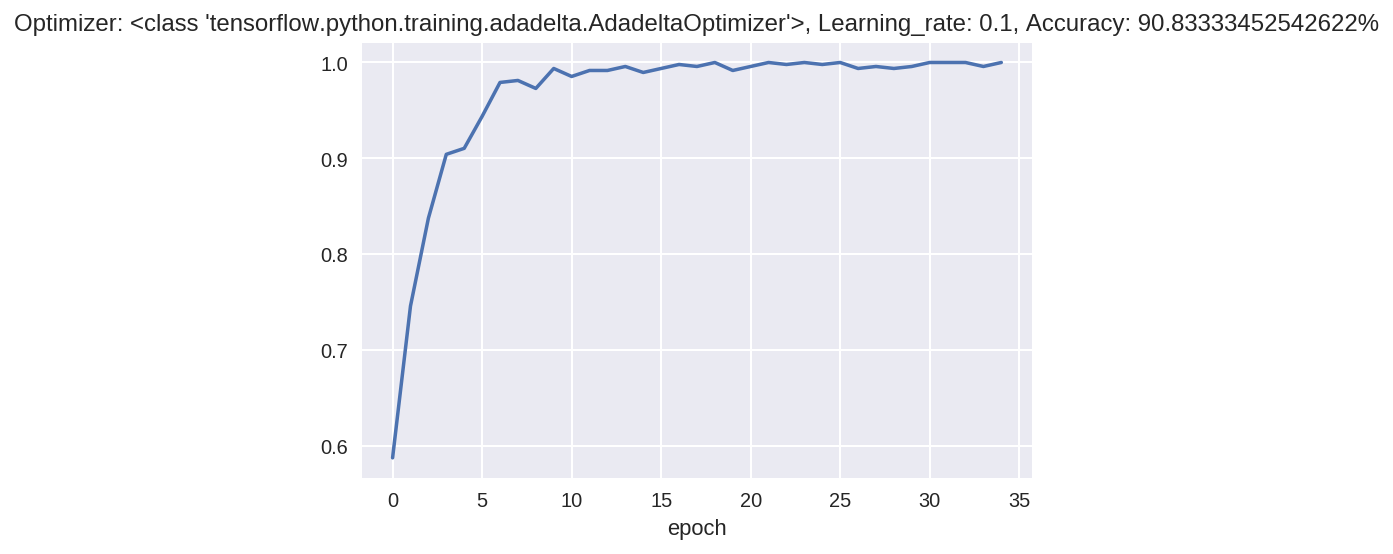

120/120 [==============================] - 28s 236ms/step


No handles with labels found to put in legend.


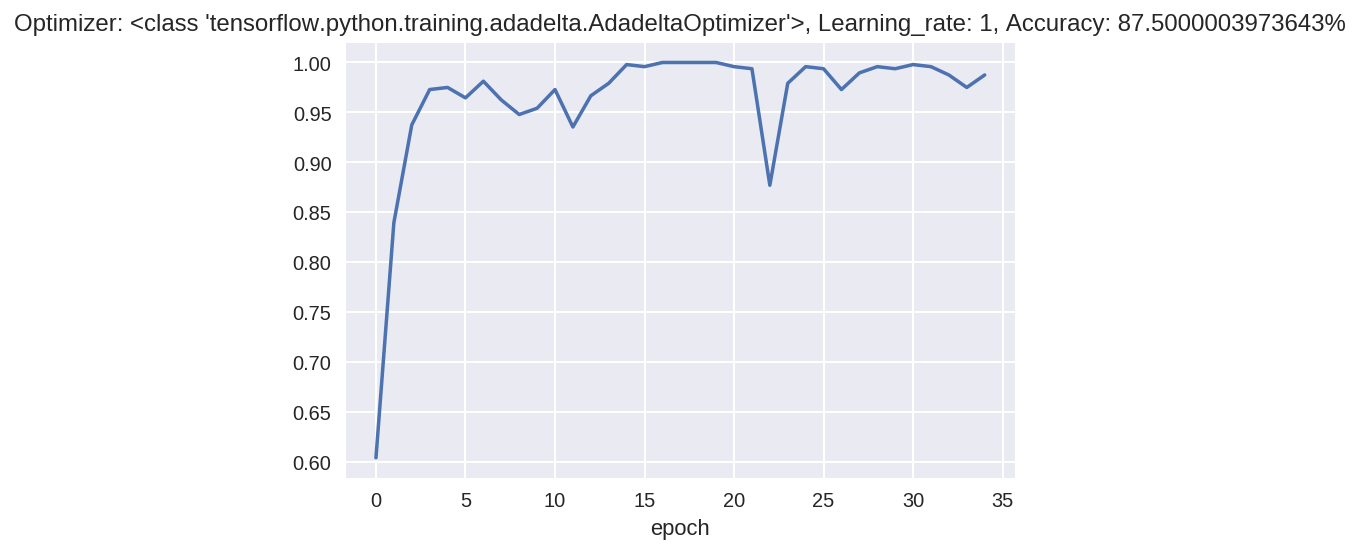

120/120 [==============================] - 32s 266ms/step


No handles with labels found to put in legend.


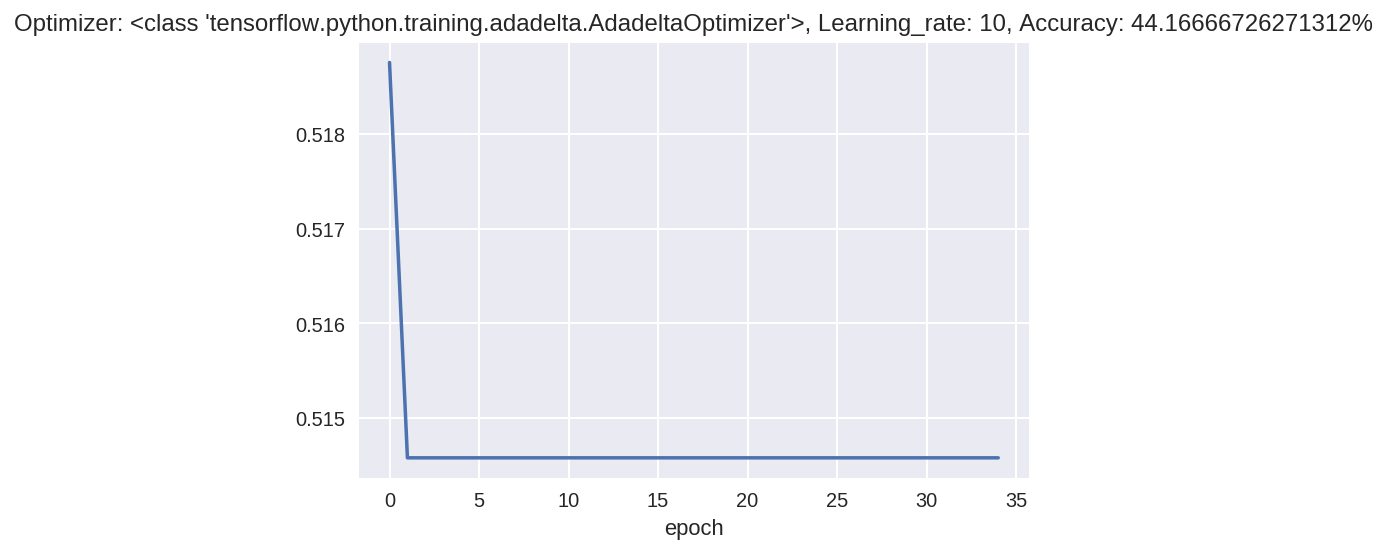

120/120 [==============================] - 38s 314ms/step


No handles with labels found to put in legend.


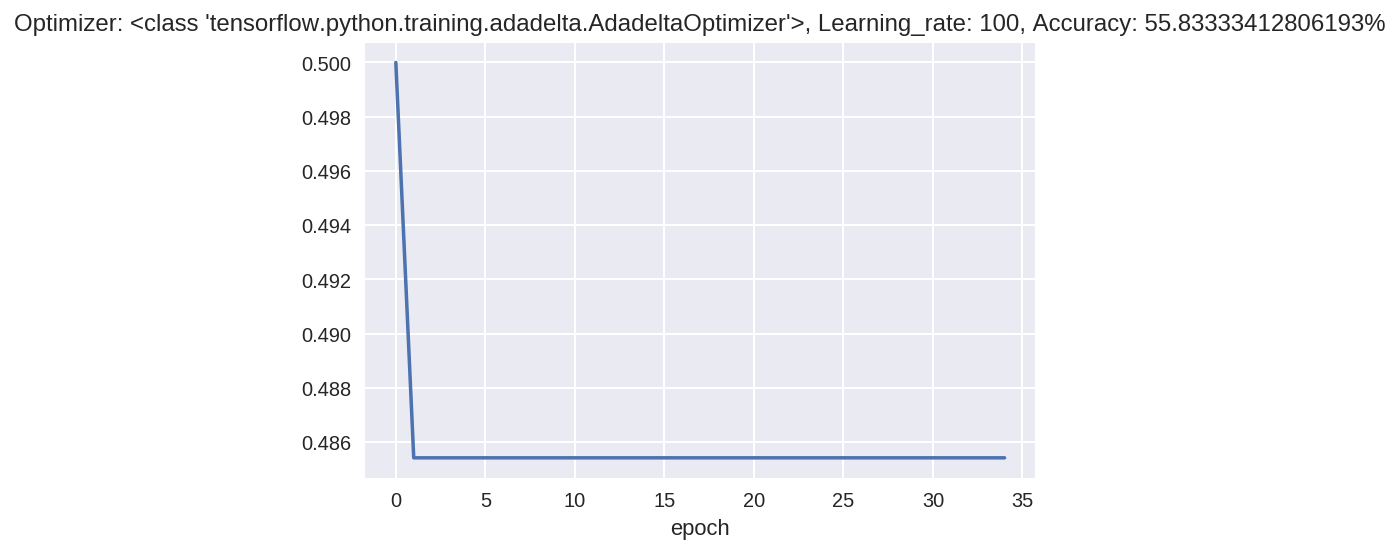

In [15]:
max_acc=-1
for lr in lrs:
    model = build_resnet()
    model.compile(optimizer=best_opt(lr), loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, Y_train, verbose = 0, epochs=EPOCHS)
    score = model.evaluate(X_val, Y_val, batch_size=BATCH_SIZE)
    plot(history, score[1], best_opt, lr)
    if score[1] >= max_acc:
        max_acc = score[1]
        best_lr = lr

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


150/150 [==============================] - 44s 295ms/step


No handles with labels found to put in legend.


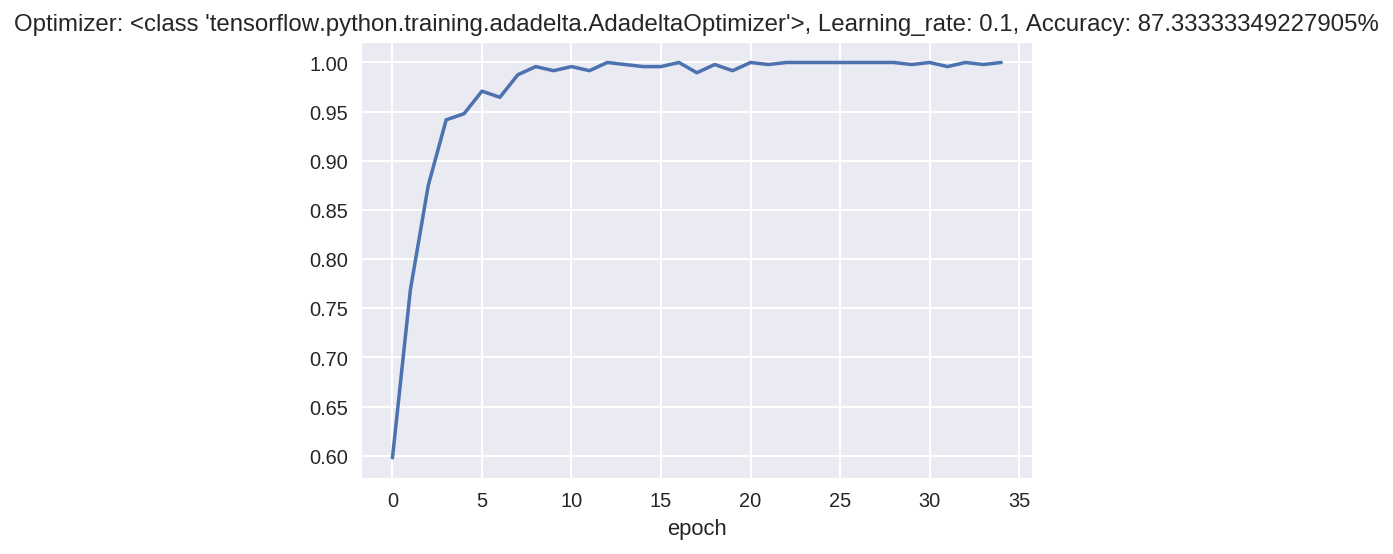

Time: 170.55523300170898


In [16]:
model = build_resnet()
start = time()
model.compile(optimizer=best_opt(best_lr), loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, Y_train, verbose = 0, epochs=EPOCHS, batch_size=BATCH_SIZE)
end = time()
score = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)
plot(history, score[1], best_opt, best_lr)
print("Time: " + str(end - start))

In [0]:
def build_resnet_pretrained():
  model = Sequential()
  model.add(ResNet50(weights= 'imagenet', include_top=False, input_shape=input_shape))
  model.add(Flatten())
  model.add(Dense(units=1, activation= 'sigmoid'))
  return model

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


120/120 [==============================] - 50s 413ms/step


No handles with labels found to put in legend.


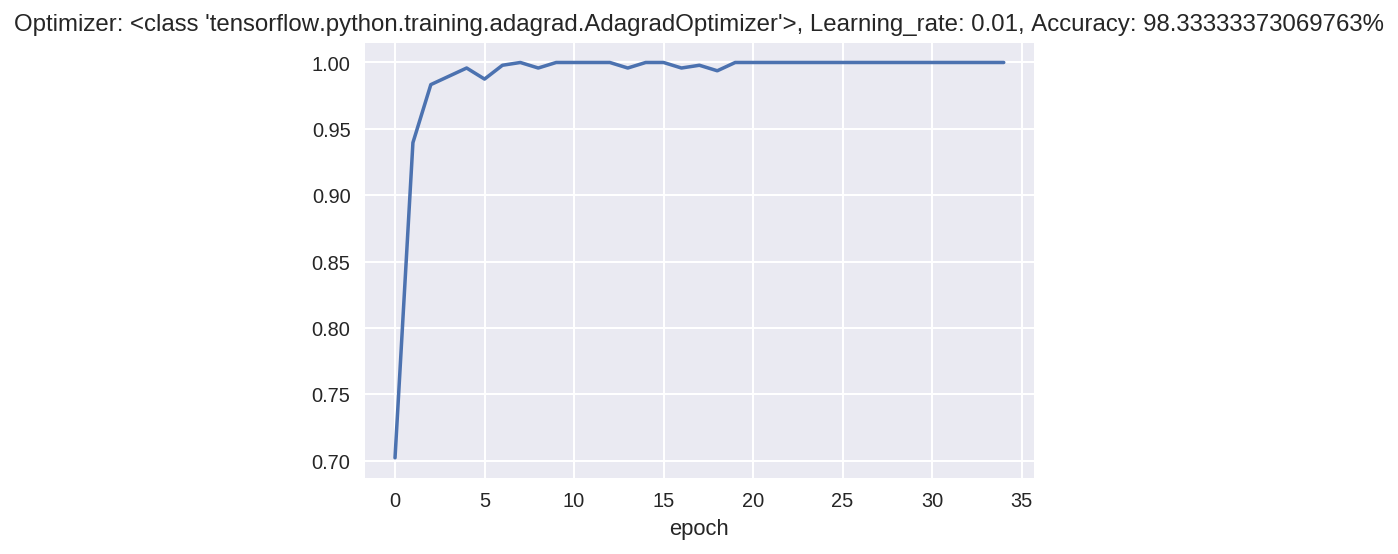

120/120 [==============================] - 58s 487ms/step


No handles with labels found to put in legend.


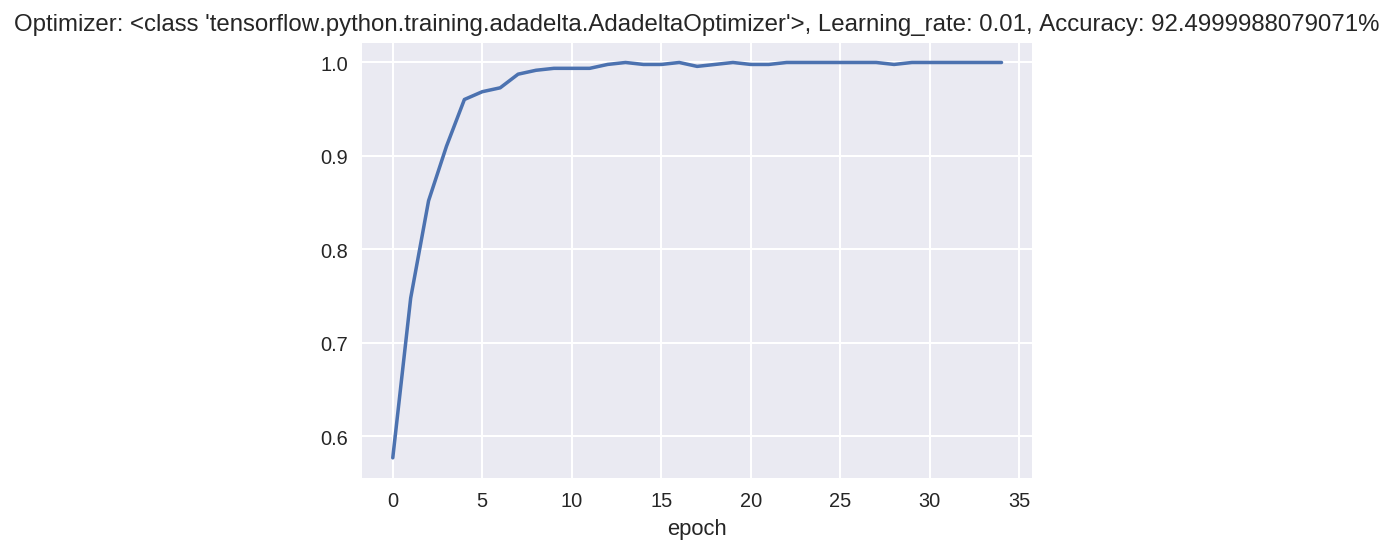

120/120 [==============================] - 65s 545ms/step


No handles with labels found to put in legend.


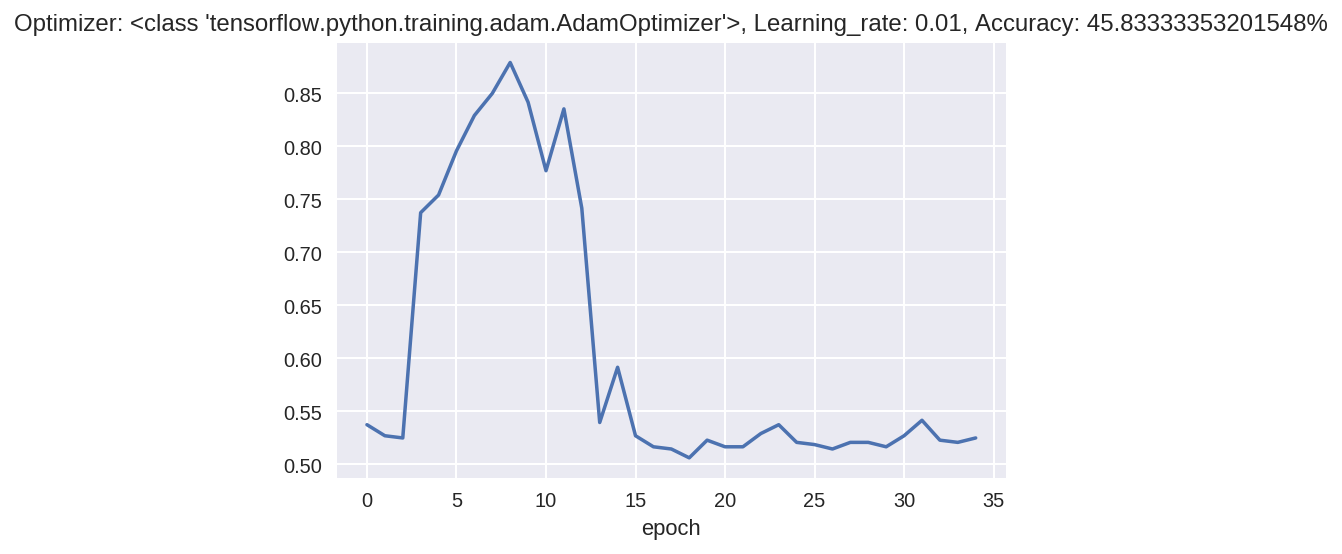

120/120 [==============================] - 73s 607ms/step


No handles with labels found to put in legend.


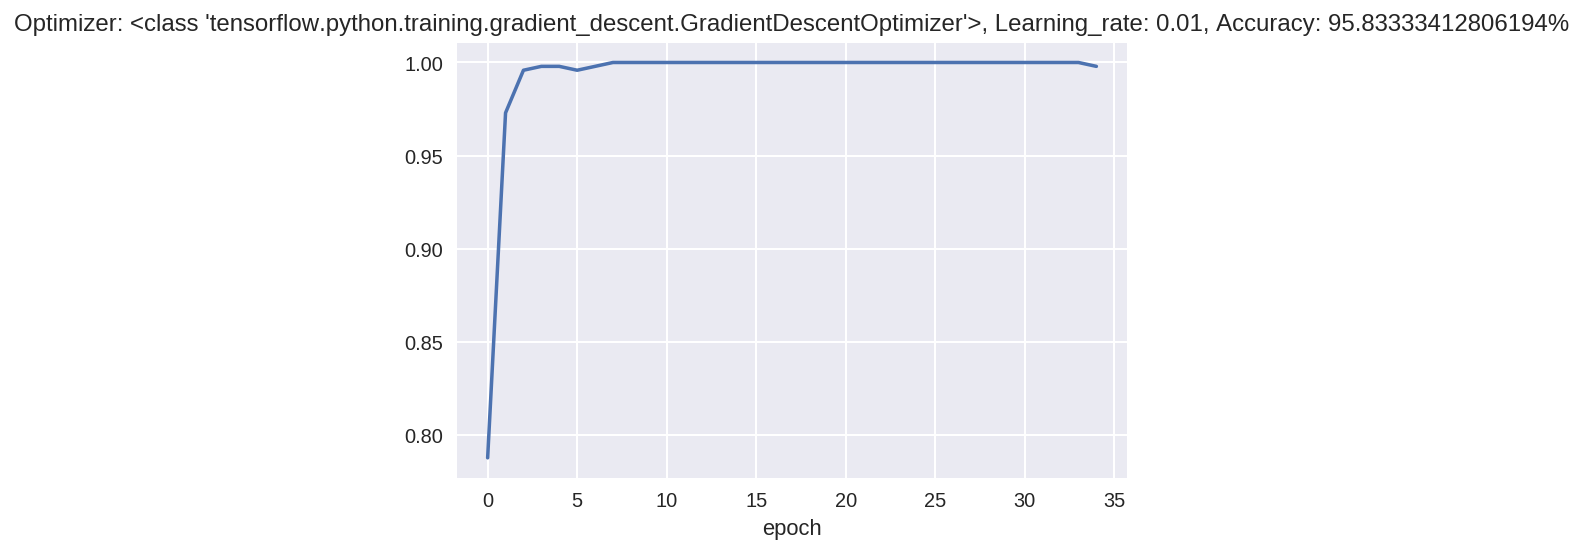

120/120 [==============================] - 79s 657ms/step


No handles with labels found to put in legend.


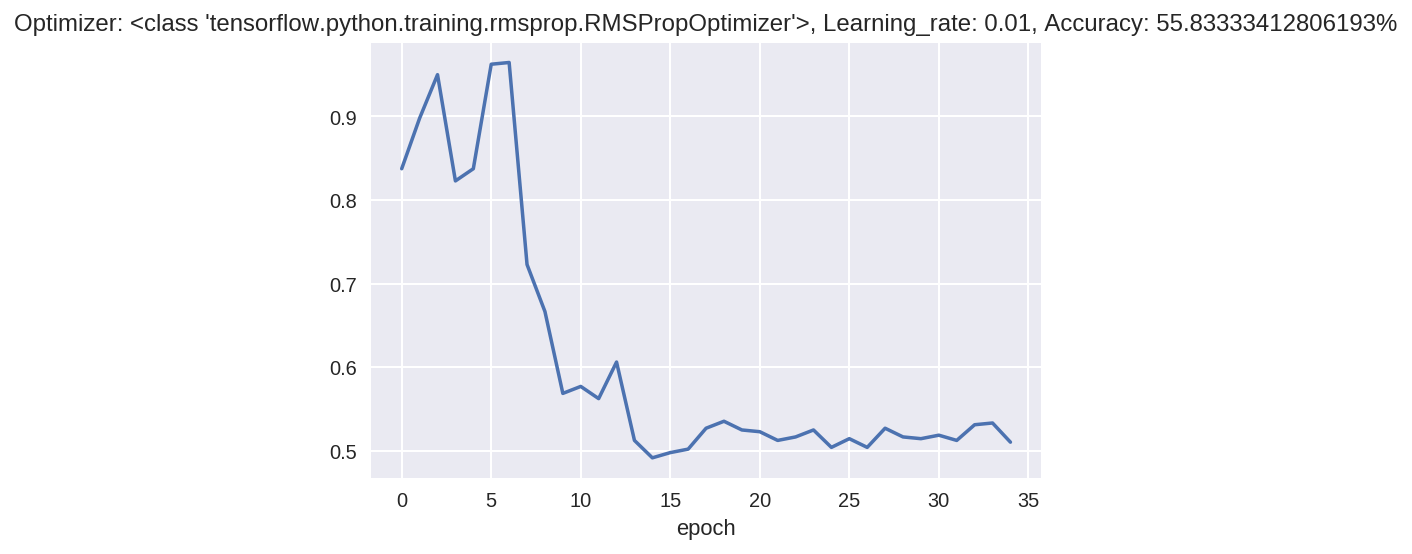

In [19]:
max_acc=-1
best_lr=.01
for optimizer in optimizers:
    model = build_resnet_pretrained()
    model.compile(optimizer=optimizer(best_lr), loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, Y_train, verbose = 0, epochs=EPOCHS, batch_size=BATCH_SIZE)
    score = model.evaluate(X_val, Y_val, batch_size=BATCH_SIZE)
    plot(history, score[1], optimizer, best_lr)
    if score[1] > max_acc:
        max_acc = score[1]
        best_opt = optimizer

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


120/120 [==============================] - 91s 756ms/step


No handles with labels found to put in legend.


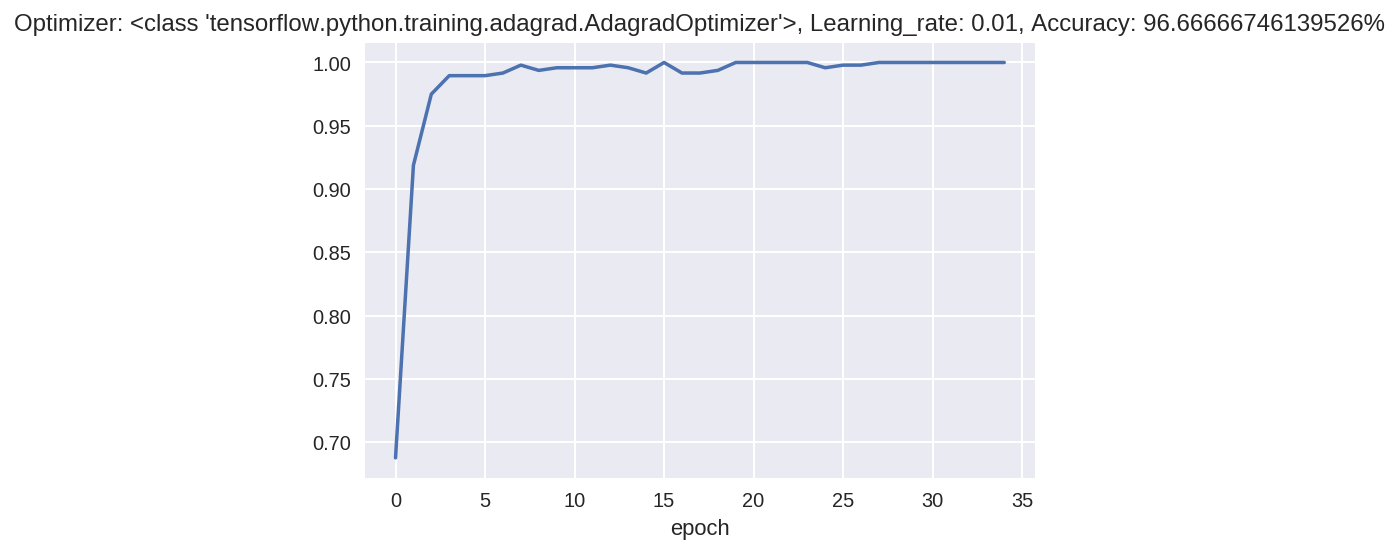

In [0]:
max_acc=-1
for lr in lrs:
    model = build_resnet_pretrained()
    model.compile(optimizer=best_opt(lr), loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, Y_train, verbose = 0, epochs=EPOCHS)
    score = model.evaluate(X_val, Y_val, batch_size=BATCH_SIZE)
    plot(history, score[1], best_opt, lr)
    if score[1] >= max_acc:
        max_acc = score[1]
        best_lr = lr